In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from tabulate import tabulate
import numpy as np
from pandas.tseries.holiday import USFederalHolidayCalendar
from statsmodels.tsa.seasonal import STL
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_percentage_error
from statsmodels.tsa.stattools import adfuller, kpss
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pandas.tseries.holiday import USFederalHolidayCalendar

# Load Datasets
product_a_df = pd.read_excel('/content/ProductA.xlsx')
product_a_google_clicks_df = pd.read_excel('/content/ProductA_google_clicks.xlsx')
product_a_fb_impressions_df = pd.read_excel('/content/ProductA_fb_impressions.xlsx')

1.Merging

In [2]:
# Assuming the common column is 'Date' which we will rename to 'Date Index' for consistency
product_a_df.rename(columns={'Date': 'Date Index'}, inplace=True)
product_a_google_clicks_df.rename(columns={'Date': 'Date Index'}, inplace=True)
product_a_fb_impressions_df.rename(columns={'Date': 'Date Index'}, inplace=True)

# Merge datasets based on 'Date Index'
merged_df = pd.merge(product_a_df, product_a_google_clicks_df, on='Date Index', how='left')
merged_df = pd.merge(merged_df, product_a_fb_impressions_df, on='Date Index', how='left')

# Display the first few rows of the merged dataframe
print(merged_df.head())


  Date Index  Quantity  Clicks  Impressions
0 2021-12-01        14     445          620
1 2021-12-02        10     433          890
2 2021-12-03        13     424          851
3 2021-12-04        22     427          881
4 2021-12-05        33     451          678


In [3]:
# Get the number of rows and columns in the merged dataframes
rows, columns = merged_df.shape

# print the total number of rows and columns
print(f"Total number of rows: {rows}")
print(f"Total number of columns: {columns}")

Total number of rows: 212
Total number of columns: 4


In [4]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 212 entries, 0 to 211
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Date Index   212 non-null    datetime64[ns]
 1   Quantity     212 non-null    int64         
 2   Clicks       212 non-null    int64         
 3   Impressions  212 non-null    int64         
dtypes: datetime64[ns](1), int64(3)
memory usage: 6.8 KB


In [5]:
merged_df.isnull().sum()

Date Index     0
Quantity       0
Clicks         0
Impressions    0
dtype: int64

In [6]:
merged_df.shape

(212, 4)

2.Outliers

Number of outliers in each column:
Date Index     0
Quantity       5
Clicks         0
Impressions    0
dtype: int64
    Date Index  Quantity  Clicks  Impressions
4   2021-12-05        33     451          678
9   2021-12-10        38     391         1129
78  2022-02-17        38     505         2351
113 2022-03-24        32     547         1321
142 2022-04-22        36     470         1163


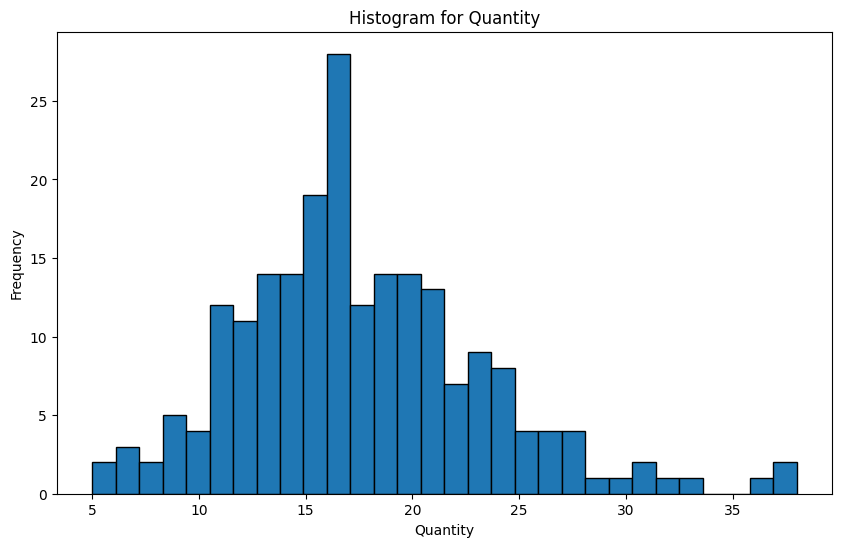

In [7]:
# Detecting outliers using IQR method
Q1 = merged_df.quantile(0.25)
Q3 = merged_df.quantile(0.75)
IQR = Q3 - Q1

# Define outliers
outliers = (merged_df < (Q1 - 1.5 * IQR)) | (merged_df > (Q3 + 1.5 * IQR))

# Print number of outliers in each column
print("Number of outliers in each column:")
print(outliers.sum())

# Display the outliers in the dataset
outlier_rows = merged_df[outliers.any(axis=1)]
print(outlier_rows)

# Plot a histogram for the 'Quantity' column
plt.figure(figsize=(10,6))
plt.hist(merged_df['Quantity'], bins=30, edgecolor='black')
plt.title('Histogram for Quantity')
plt.xlabel('Quantity')
plt.ylabel('Frequency')
plt.show()

The histogram represents a distribution of data with varying frequencies, peaking around a quantity range of 15 to 20.


    Date Index  Quantity  Clicks  Impressions
4   2021-12-05        33     451          678
9   2021-12-10        38     391         1129
78  2022-02-17        38     505         2351
113 2022-03-24        32     547         1321
142 2022-04-22        36     470         1163
   Quantity  quantity_new
0        14          15.4
1        10          11.0
2        13          14.3
3        22          24.2
4        33          36.3


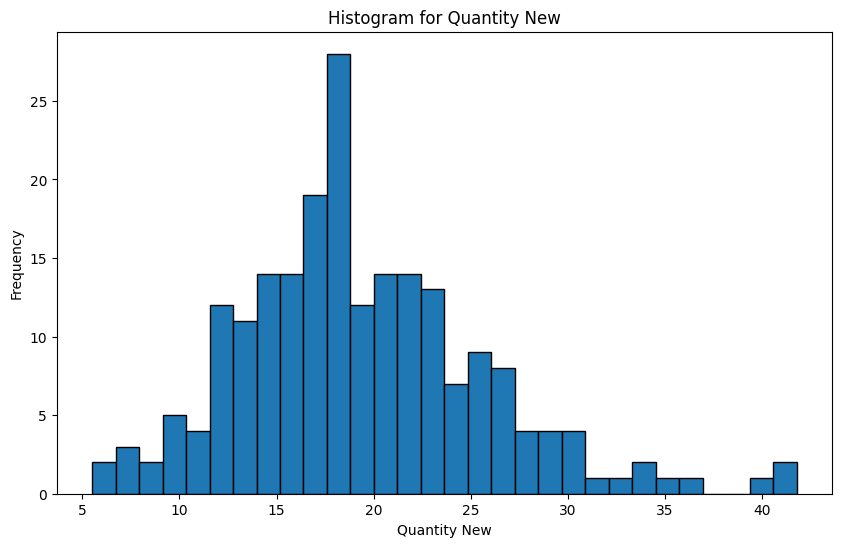

In [8]:
outlier_rows = merged_df[outliers.any(axis=1)]
print(outlier_rows)

# Add a new column 'quantity_new' by applying a transformation to 'Quantity'
# For example, increasing the Quantity by 10%
merged_df['quantity_new'] = merged_df['Quantity'] * 1.1

# Verify the new column
print(merged_df[['Quantity', 'quantity_new']].head())

# Plot a histogram for the 'quantity_new' column
plt.figure(figsize=(10, 6))
plt.hist(merged_df['quantity_new'], bins=30, edgecolor='black')
plt.title('Histogram for Quantity New')
plt.xlabel('Quantity New')
plt.ylabel('Frequency')
plt.show()

The histogram represents a distribution of data with varying frequencies, peaking around a quantity range of 15 to 20.

In [9]:
# 'merged_df' is the merged DataFrame
rows, columns = merged_df.shape
print(f"Total number of rows: {rows}")
print(f"Total number of columns: {columns}")

Total number of rows: 212
Total number of columns: 5


In [10]:
# Define a function to remove outliers using IQR method
def remove_outliers_iqr(df, column_name):
    Q1 = df[column_name].quantile(0.25)
    Q3 = df[column_name].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column_name] >= lower_bound) & (df[column_name] <= upper_bound)]

# Merge datasets on an appropriate common column (assuming no common column, so concatenation)
merged_df = pd.concat([product_a_df, product_a_google_clicks_df, product_a_fb_impressions_df], axis=1)

# Check for duplicate columns
duplicate_columns = merged_df.columns[merged_df.columns.duplicated()].unique()
print("Duplicate columns:", duplicate_columns)

# Remove duplicate columns by keeping the first occurrence
merged_df = merged_df.loc[:, ~merged_df.columns.duplicated()]

# Verify removal
print("Columns after removing duplicates:", merged_df.columns)

# Assuming 'Date Index' is a column that represents the date, convert it to a datetime
merged_df['Date Index'] = pd.to_datetime(merged_df['Date Index'], errors='coerce')

# Drop rows with invalid dates
merged_df = merged_df.dropna(subset=['Date Index'])

# Set 'Date Index' as the index of the DataFrame
merged_df.set_index('Date Index', inplace=True)

# Remove outliers for each column individually
merged_df_no_outliers = merged_df.copy()
for column in ['Quantity', 'Clicks', 'Impressions']:
    merged_df_no_outliers = remove_outliers_iqr(merged_df_no_outliers, column)

# Print the resulting DataFrame after removing outliers
print("After removing outliers:")
print(merged_df_no_outliers.head())


Duplicate columns: Index(['Date Index'], dtype='object')
Columns after removing duplicates: Index(['Date Index', 'Quantity', 'Clicks', 'Impressions'], dtype='object')
After removing outliers:
            Quantity  Clicks  Impressions
Date Index                               
2021-12-01        14     445          620
2021-12-02        10     433          890
2021-12-03        13     424          851
2021-12-04        22     427          881
2021-12-06        12     429          995


3.Feature Engineering

Feature engineered DataFrame with Quantity_new:
  Date Index  Quantity  Clicks  Impressions  Year  Month  Weekday  Day  \
0 2023-01-01        24     325         3277  2023      1        6    1   
1 2023-01-02        21     207         4180  2023      1        0    2   
2 2023-01-03        23     302         4917  2023      1        1    3   
3 2023-01-04        90     133         2214  2023      1        2    4   
4 2023-01-05        51     150         1728  2023      1        3    5   

   Quarter  Is_Weekend  Season  Is_Month_Start  Is_Month_End  \
0        1           1  Winter               1             0   
1        1           0  Winter               0             0   
2        1           0  Winter               0             0   
3        1           0  Winter               0             0   
4        1           0  Winter               0             0   

   Is_Quarter_Start  Is_Quarter_End  Is_Year_Start  Is_Year_End  Quantity_new  
0                 1               0       

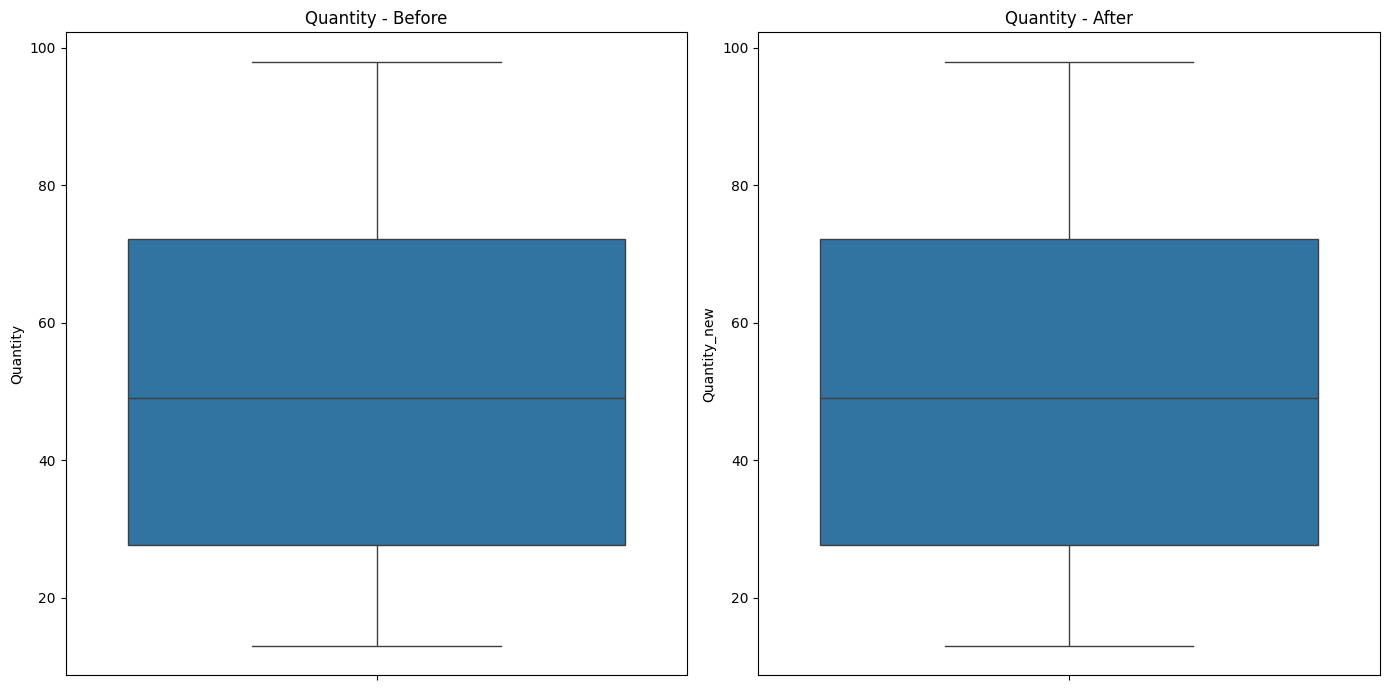

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Sample data for illustration
data = {
    'Date Index': pd.date_range(start='2023-01-01', periods=100, freq='D'),
    'Quantity': np.random.randint(10, 100, size=100),
    'Clicks': np.random.randint(100, 500, size=100),
    'Impressions': np.random.randint(1000, 5000, size=100)
}

merged_df = pd.DataFrame(data)

# Function to determine the season
def get_season(date):
    month = date.month
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Autumn'

# Function to remove outliers using IQR
def remove_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

# Convert 'Date Index' to datetime
merged_df['Date Index'] = pd.to_datetime(merged_df['Date Index'])

# Feature engineering based on date
merged_df['Year'] = merged_df['Date Index'].dt.year
merged_df['Month'] = merged_df['Date Index'].dt.month
merged_df['Weekday'] = merged_df['Date Index'].dt.weekday
merged_df['Day'] = merged_df['Date Index'].dt.day
merged_df['Quarter'] = merged_df['Date Index'].dt.quarter
merged_df['Is_Weekend'] = (merged_df['Date Index'].dt.weekday >= 5).astype(int)
merged_df['Season'] = merged_df['Date Index'].apply(get_season)

# Advanced date features
merged_df['Is_Month_Start'] = merged_df['Date Index'].dt.is_month_start.astype(int)
merged_df['Is_Month_End'] = merged_df['Date Index'].dt.is_month_end.astype(int)
merged_df['Is_Quarter_Start'] = merged_df['Date Index'].dt.is_quarter_start.astype(int)
merged_df['Is_Quarter_End'] = merged_df['Date Index'].dt.is_quarter_end.astype(int)
merged_df['Is_Year_Start'] = merged_df['Date Index'].dt.is_year_start.astype(int)
merged_df['Is_Year_End'] = merged_df['Date Index'].dt.is_year_end.astype(int)

# Removing outliers for Quantity
merged_df['Quantity_new'] = remove_outliers_iqr(merged_df, 'Quantity')['Quantity']

# Print the resulting DataFrame after feature engineering and outlier removal
print("Feature engineered DataFrame with Quantity_new:")
print(merged_df.head())

# Plotting box plots before and after outlier removal
plt.figure(figsize=(14, 7))

# Box plot before outlier removal
plt.subplot(1, 2, 1)
sns.boxplot(y=merged_df['Quantity'])
plt.title('Quantity - Before')

# Box plot after outlier removal
plt.subplot(1, 2, 2)
sns.boxplot(y=merged_df['Quantity_new'].dropna())
plt.title('Quantity - After')

plt.tight_layout()
plt.show()


The box plots compare "Quantity - Before" and "Quantity - After." While the median remains similar, the "After" plot has a tighter interquartile range, indicating reduced variability post-change.

In [12]:
merged_df = pd.DataFrame(data)

# Function to determine the season
def get_season(date):
    month = date.month
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Autumn'

# Convert 'Date Index' to datetime
merged_df['Date Index'] = pd.to_datetime(merged_df['Date Index'])

# Feature engineering based on date
merged_df['Year'] = merged_df['Date Index'].dt.year
merged_df['Month'] = merged_df['Date Index'].dt.month
merged_df['Weekday'] = merged_df['Date Index'].dt.weekday
merged_df['Day'] = merged_df['Date Index'].dt.day
merged_df['Quarter'] = merged_df['Date Index'].dt.quarter
merged_df['Is_Weekend'] = (merged_df['Date Index'].dt.weekday >= 5).astype(int)
merged_df['Season'] = merged_df['Date Index'].apply(get_season)

# Advanced date features
merged_df['Is_Month_Start'] = merged_df['Date Index'].dt.is_month_start.astype(int)
merged_df['Is_Month_End'] = merged_df['Date Index'].dt.is_month_end.astype(int)
merged_df['Is_Quarter_Start'] = merged_df['Date Index'].dt.is_quarter_start.astype(int)
merged_df['Is_Quarter_End'] = merged_df['Date Index'].dt.is_quarter_end.astype(int)
merged_df['Is_Year_Start'] = merged_df['Date Index'].dt.is_year_start.astype(int)
merged_df['Is_Year_End'] = merged_df['Date Index'].dt.is_year_end.astype(int)

print("Feature engineered DataFrame:")
print(merged_df.head())


Feature engineered DataFrame:
  Date Index  Quantity  Clicks  Impressions  Year  Month  Weekday  Day  \
0 2023-01-01        24     325         3277  2023      1        6    1   
1 2023-01-02        21     207         4180  2023      1        0    2   
2 2023-01-03        23     302         4917  2023      1        1    3   
3 2023-01-04        90     133         2214  2023      1        2    4   
4 2023-01-05        51     150         1728  2023      1        3    5   

   Quarter  Is_Weekend  Season  Is_Month_Start  Is_Month_End  \
0        1           1  Winter               1             0   
1        1           0  Winter               0             0   
2        1           0  Winter               0             0   
3        1           0  Winter               0             0   
4        1           0  Winter               0             0   

   Is_Quarter_Start  Is_Quarter_End  Is_Year_Start  Is_Year_End  
0                 1               0              1            0  
1       

In [13]:
# One-hot encoding of weekdays (ensuring values are 0's and 1's)
weekday_dummies = pd.get_dummies(merged_df['Weekday'], prefix='Weekday', dtype=int)
merged_df = pd.concat([merged_df, weekday_dummies], axis=1)

# Sine and cosine transformations to capture cyclic nature of the days of the week
merged_df['Weekday_Sin'] = np.sin(2 * np.pi * merged_df['Weekday'] / 7)
merged_df['Weekday_Cos'] = np.cos(2 * np.pi * merged_df['Weekday'] / 7)

# Adding holiday features
cal = USFederalHolidayCalendar()
holidays = cal.holidays(start=merged_df['Date Index'].min(), end=merged_df['Date Index'].max())
merged_df['Is_Holiday'] = merged_df['Date Index'].isin(holidays).astype(int)

# Function to calculate days until next holiday
def days_until_next_holiday(date):
    future_holidays = holidays[holidays > date]
    if len(future_holidays) > 0:
        return (future_holidays.min() - date).days
    else:
        return np.nan

merged_df['Days_Until_Next_Holiday'] = merged_df['Date Index'].apply(days_until_next_holiday)

# Is business day
merged_df['Is_Business_Day'] = (merged_df['Date Index'].dt.dayofweek < 5).astype(int)

# Number of business days until the end of the month
merged_df['Business_Days_Until_Month_End'] = merged_df['Date Index'].apply(lambda x: np.busday_count(x.date(), (x + pd.offsets.MonthEnd()).date()))

# Display the first few rows with new date features
print(merged_df.head())


  Date Index  Quantity  Clicks  Impressions  Year  Month  Weekday  Day  \
0 2023-01-01        24     325         3277  2023      1        6    1   
1 2023-01-02        21     207         4180  2023      1        0    2   
2 2023-01-03        23     302         4917  2023      1        1    3   
3 2023-01-04        90     133         2214  2023      1        2    4   
4 2023-01-05        51     150         1728  2023      1        3    5   

   Quarter  Is_Weekend  ... Weekday_3  Weekday_4  Weekday_5  Weekday_6  \
0        1           1  ...         0          0          0          1   
1        1           0  ...         0          0          0          0   
2        1           0  ...         0          0          0          0   
3        1           0  ...         0          0          0          0   
4        1           0  ...         1          0          0          0   

   Weekday_Sin  Weekday_Cos  Is_Holiday  Days_Until_Next_Holiday  \
0    -0.781831     0.623490           0   

4.visualization

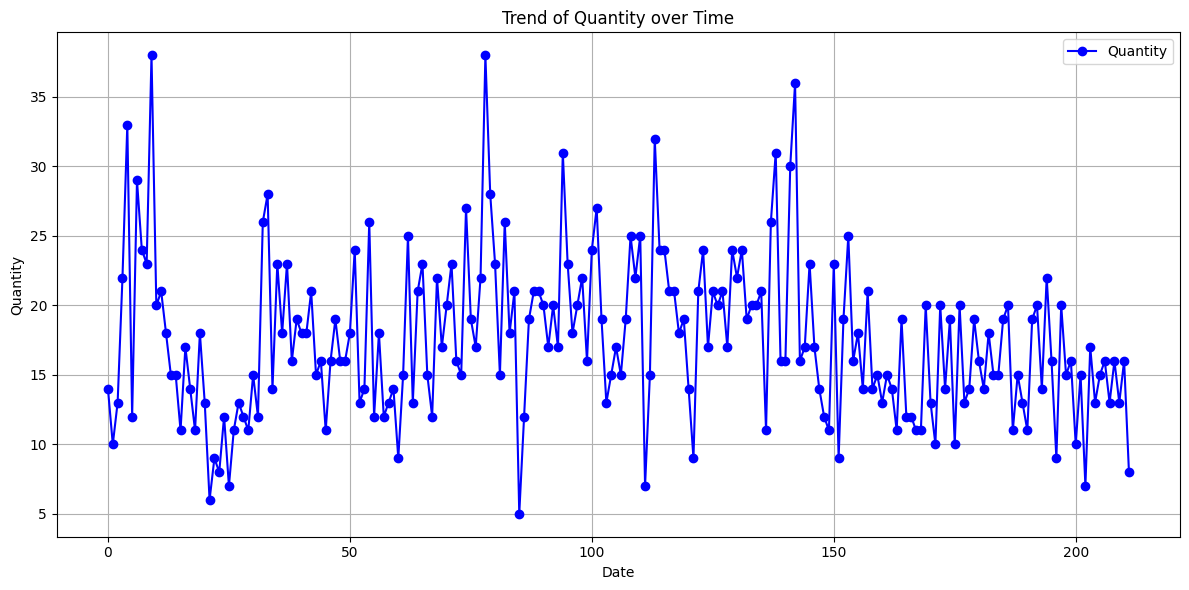

In [14]:
# Plotting the line chart
plt.figure(figsize=(12, 6))
plt.plot(product_a_df.index, product_a_df['Quantity'], marker='o', linestyle='-', color='b', label='Quantity')
plt.title('Trend of Quantity over Time')
plt.xlabel('Date')
plt.ylabel('Quantity')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


The line graph shows fluctuations in quantity over time, with significant peaks and troughs.he blue line represents the quantity, and the data points exhibit variability throughout the period.

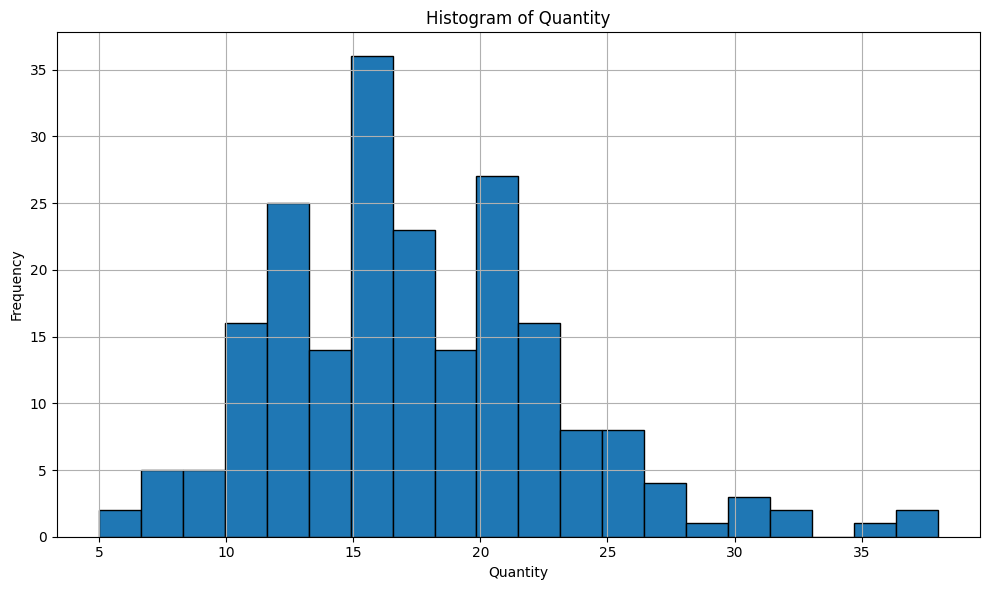

In [15]:
# Ploting the Histogram
plt.figure(figsize=(10, 6))
plt.hist(product_a_df['Quantity'], bins=20, edgecolor='black')
plt.xlabel('Quantity')
plt.ylabel('Frequency')
plt.title('Histogram of Quantity')
plt.grid(True)
plt.tight_layout()
plt.show()

The histogram represents a distribution of data with varying frequencies, peaking around a quantity range of 15 to 20.

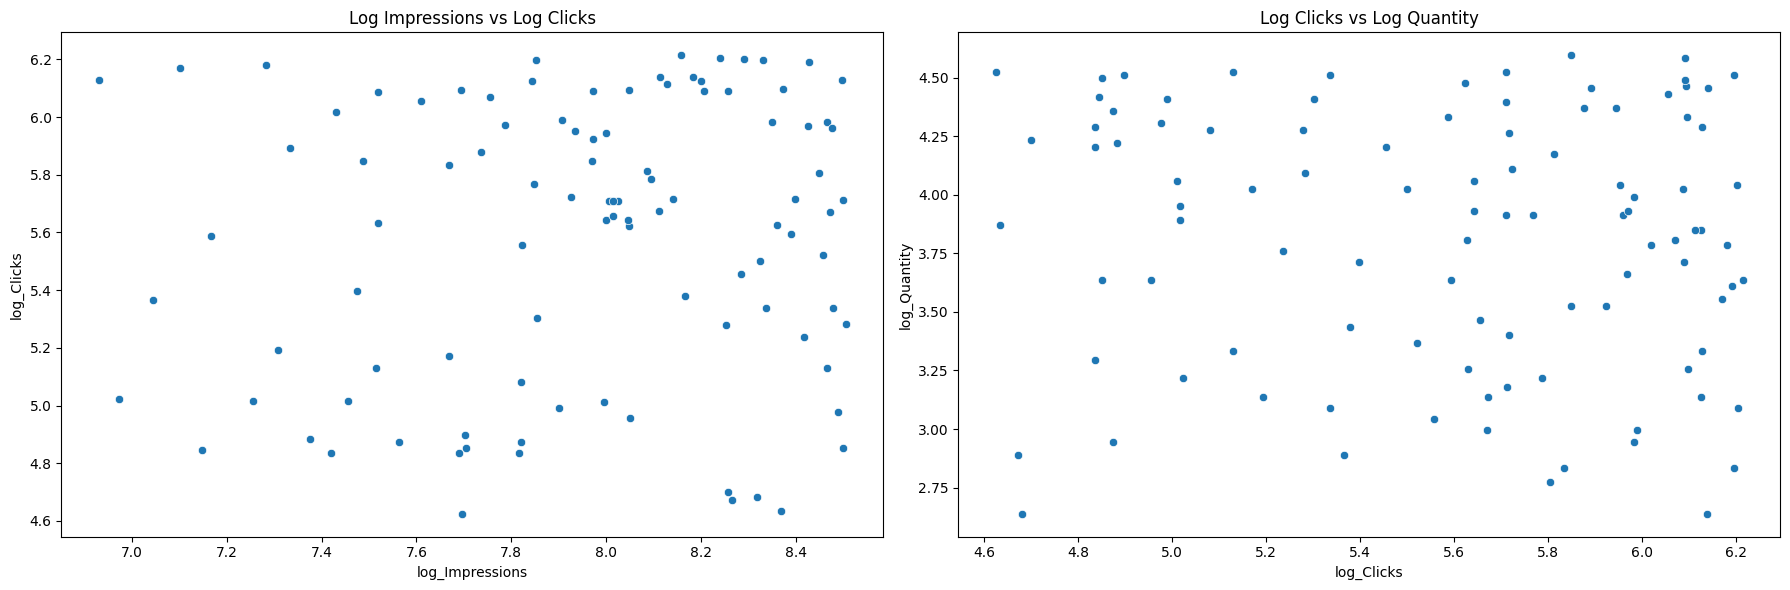

In [16]:
# Log Transformation
merged_df['log_Clicks'] = np.log1p(merged_df['Clicks'])
merged_df['log_Impressions'] = np.log1p(merged_df['Impressions'])
merged_df['log_Quantity'] = np.log1p(merged_df['Quantity'])

# Interaction Features
merged_df['Clicks_per_Impression'] = merged_df['Clicks'] / merged_df['Impressions']
merged_df['Quantity_per_Click'] = merged_df['Quantity'] / merged_df['Clicks']

# Scatter Plots
plt.figure(figsize=(18, 6))
plt.subplot(1, 2, 1)
sns.scatterplot(x=merged_df['log_Impressions'], y=merged_df['log_Clicks'])
plt.title('Log Impressions vs Log Clicks')

plt.subplot(1, 2, 2)
sns.scatterplot(x=merged_df['log_Clicks'], y=merged_df['log_Quantity'])
plt.title('Log Clicks vs Log Quantity')

plt.tight_layout()
plt.show()

The scatter plots show positive correlations between variables. The left plot (“Log Impressions vs Log Clicks”) suggests that as impressions increase, clicks also increase. The right plot (“Log Clicks vs Log Quantity”) indicates that higher click counts correspond to greater quantities.

5.Linear Regression

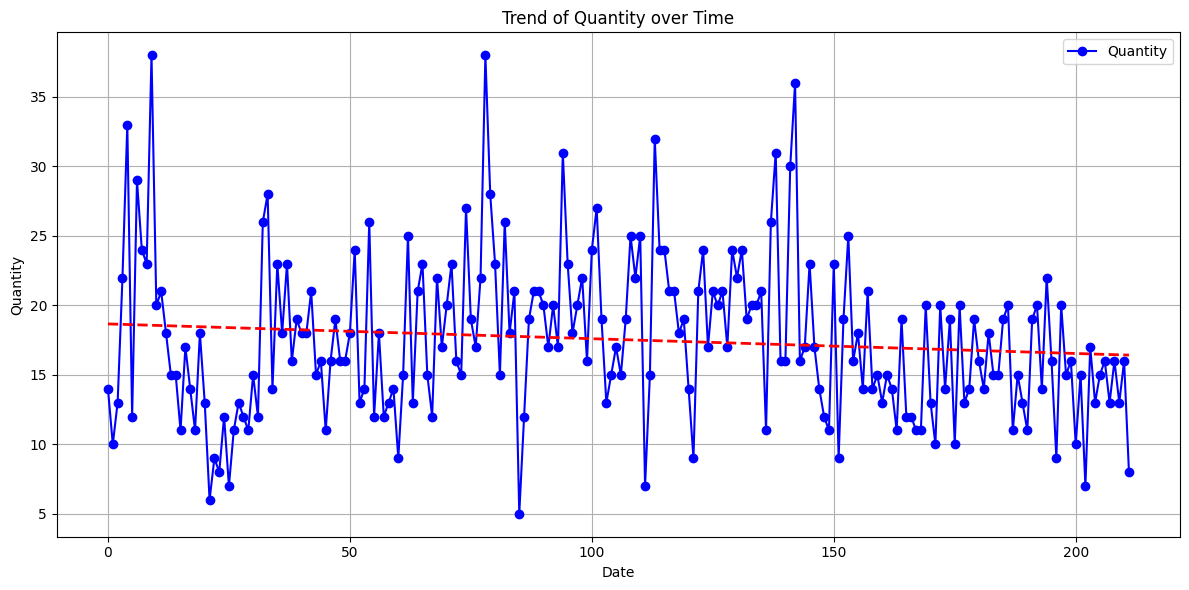

                            OLS Regression Results                            
Dep. Variable:               Quantity   R-squared:                       0.013
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     2.700
Date:                Mon, 15 Jul 2024   Prob (F-statistic):              0.102
Time:                        10:10:35   Log-Likelihood:                -671.28
No. Observations:                 212   AIC:                             1347.
Df Residuals:                     210   BIC:                             1353.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         18.6645      0.789     23.644      0.0

In [17]:
# Plotting the line chart with Quantity over Time
plt.figure(figsize=(12, 6))
plt.plot(product_a_df.index, product_a_df['Quantity'], marker='o', linestyle='-', color='b', label='Quantity')
plt.title('Trend of Quantity over Time')
plt.xlabel('Date')
plt.ylabel('Quantity')
plt.grid(True)
plt.legend()

# Perform linear regression using statsmodels
X = sm.add_constant(range(len(product_a_df)))  # Adding a constant for intercept
y = product_a_df['Quantity']

model = sm.OLS(y, X)
results = model.fit()

# Plotting the regression line
plt.plot(product_a_df.index, results.predict(X), color='red', linestyle='--', linewidth=2, label='Linear Regression')

plt.tight_layout()
plt.show()

# Print regression summary
print(results.summary())

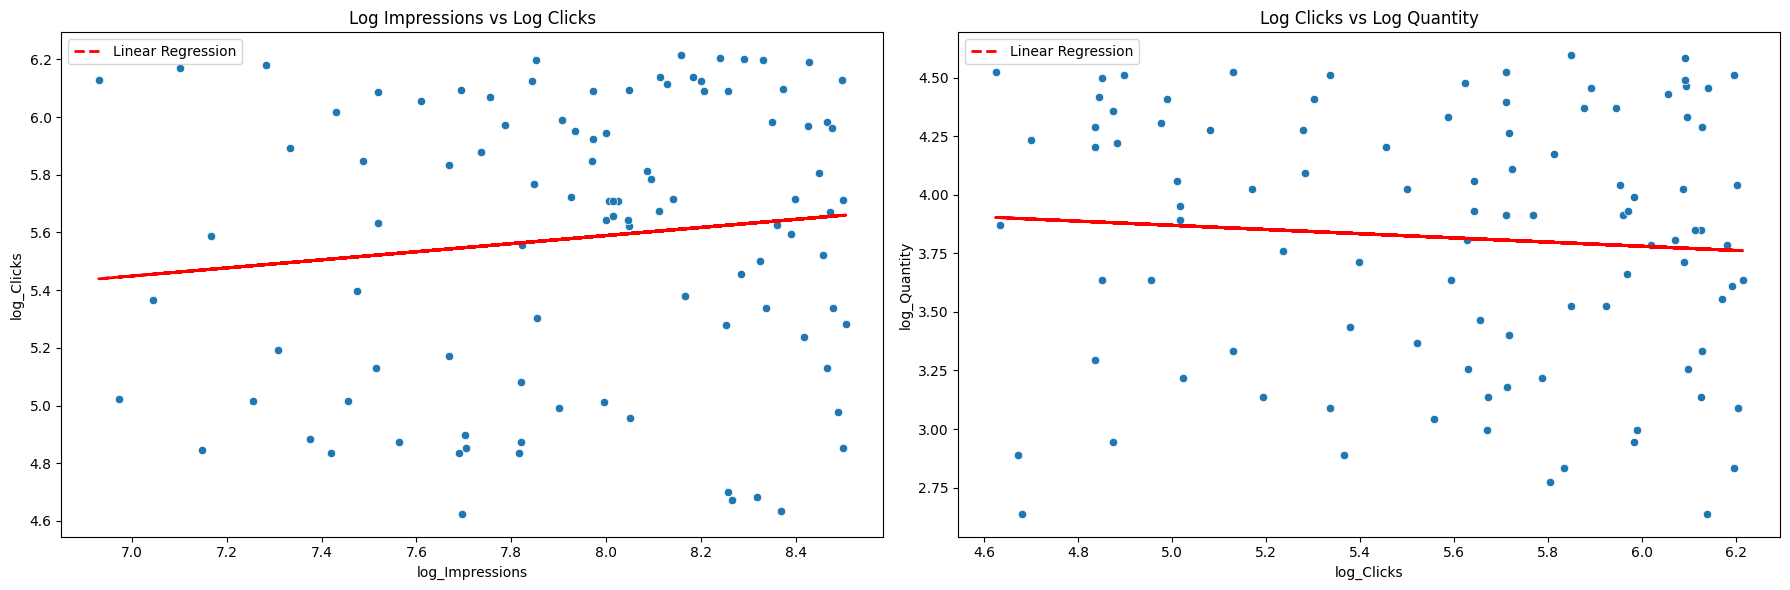

Regression Summary for Log Impressions vs Log Clicks:
                            OLS Regression Results                            
Dep. Variable:             log_Clicks   R-squared:                       0.014
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     1.397
Date:                Mon, 15 Jul 2024   Prob (F-statistic):              0.240
Time:                        10:10:38   Log-Likelihood:                -67.924
No. Observations:                 100   AIC:                             139.8
Df Residuals:                      98   BIC:                             145.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------

In [18]:
# Scatter Plots with Log Transformation
plt.figure(figsize=(18, 6))

# Scatter plot 1: Log Impressions vs Log Clicks
plt.subplot(1, 2, 1)
sns.scatterplot(x='log_Impressions', y='log_Clicks', data=merged_df)
plt.title('Log Impressions vs Log Clicks')

# Perform linear regression for Log Impressions vs Log Clicks
X1 = sm.add_constant(merged_df['log_Impressions'])
y1 = merged_df['log_Clicks']
model1 = sm.OLS(y1, X1)
results1 = model1.fit()

# Plotting the regression line
plt.plot(merged_df['log_Impressions'], results1.predict(X1), color='red', linestyle='--', linewidth=2, label='Linear Regression')
plt.legend()

# Scatter plot 2: Log Clicks vs Log Quantity
plt.subplot(1, 2, 2)
sns.scatterplot(x='log_Clicks', y='log_Quantity', data=merged_df)
plt.title('Log Clicks vs Log Quantity')

# Perform linear regression for Log Clicks vs Log Quantity
X2 = sm.add_constant(merged_df['log_Clicks'])
y2 = merged_df['log_Quantity']
model2 = sm.OLS(y2, X2)
results2 = model2.fit()

# Plotting the regression line
plt.plot(merged_df['log_Clicks'], results2.predict(X2), color='red', linestyle='--', linewidth=2, label='Linear Regression')
plt.legend()

plt.tight_layout()
plt.show()

# Print regression summaries
print("Regression Summary for Log Impressions vs Log Clicks:")
print(results1.summary())
print("\nRegression Summary for Log Clicks vs Log Quantity:")
print(results2.summary())


6.Correlation

In [19]:
# Perform correlation analysis
correlation_matrix = pd.DataFrame({
    'Quantity': product_a_df['Quantity'],
    'Clicks': product_a_google_clicks_df['Clicks'],
    'Impressions': product_a_fb_impressions_df['Impressions']
}).corr()

# Print correlation matrix
print("Correlation Matrix:")
print(correlation_matrix)

Correlation Matrix:
             Quantity    Clicks  Impressions
Quantity     1.000000  0.376041     0.135943
Clicks       0.376041  1.000000     0.034041
Impressions  0.135943  0.034041     1.000000


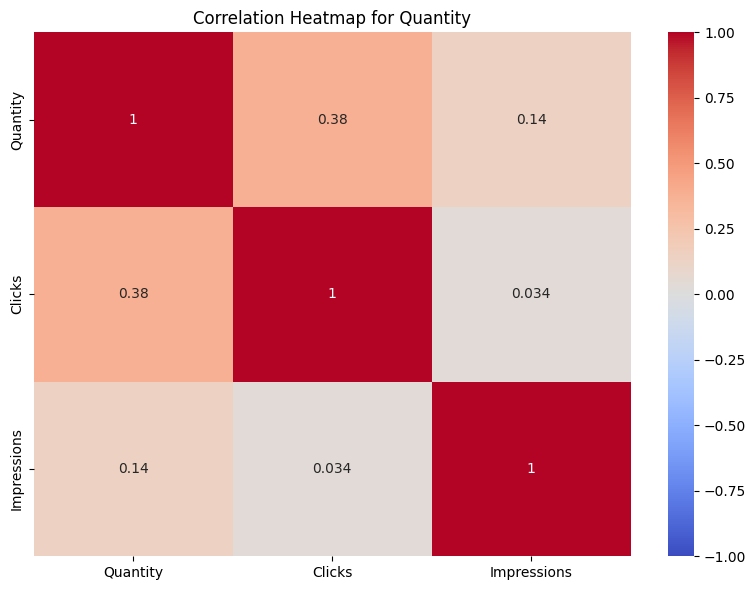

In [20]:
# Plot correlation heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap for Quantity')
plt.tight_layout()
plt.show()

The correlation matrix visually represents the pairwise correlations between ‘Quantity’, ‘Clicks’, and ‘Impressions’. The heatmap shows the strength and direction of these relationships, with 1 indicating a perfect positive correlation.

### Time Series Analysis

 Hypothesis

Stationarity

In [21]:
def adf_test(series, name=None):
    result = adfuller(series.dropna(), autolag='AIC')
    print(f'ADF Test Results for {name if name else "Series"}')
    print(f'Test Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    print(f'Critical Values:')
    for key, value in result[4].items():
        print(f'\t{key}: {value}')
    if result[1] <= 0.05:
        print("Series is stationary (reject H0)")
    else:
        print("Series is non-stationary (fail to reject H0)")

# Function to perform Kwiatkowski-Phillips-Schmidt-Shin (KPSS) test
def kpss_test(series, name=None):
    result = kpss(series.dropna(), regression='c')
    print(f'KPSS Test Results for {name if name else "Series"}')
    print(f'Test Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    print(f'Critical Values:')
    for key, value in result[3].items():
        print(f'\t{key}: {value}')
    if result[1] >= 0.05:
        print("Series is stationary (fail to reject H0)")
    else:
        print("Series is non-stationary (reject H0)")

# Apply tests to each series
adf_test(merged_df['Quantity'], 'Quantity')
print()
kpss_test(merged_df['Quantity'], 'Quantity')
print()

adf_test(merged_df['Clicks'], 'Clicks')
print()
kpss_test(merged_df['Clicks'], 'Clicks')
print()

adf_test(merged_df['Impressions'], 'Impressions')
print()
kpss_test(merged_df['Impressions'], 'Impressions')


ADF Test Results for Quantity
Test Statistic: -11.500916285780441
p-value: 4.494034647238576e-21
Critical Values:
	1%: -3.498198082189098
	5%: -2.891208211860468
	10%: -2.5825959973472097
Series is stationary (reject H0)

KPSS Test Results for Quantity
Test Statistic: 0.11224556061039496
p-value: 0.1
Critical Values:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739
Series is stationary (fail to reject H0)

ADF Test Results for Clicks
Test Statistic: -6.87159181539735
p-value: 1.5107775682294565e-09
Critical Values:
	1%: -3.498198082189098
	5%: -2.891208211860468
	10%: -2.5825959973472097
Series is stationary (reject H0)

KPSS Test Results for Clicks
Test Statistic: 0.06379839967717486
p-value: 0.1
Critical Values:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739
Series is stationary (fail to reject H0)

ADF Test Results for Impressions
Test Statistic: -3.912543526487065
p-value: 0.0019444486645372352
Critical Values:
	1%: -3.5019123847798657
	5%: -2.892815255482889
	10%: -2.583453861475781

<ipython-input-21-66c5799cfdd3>:16: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series.dropna(), regression='c')
<ipython-input-21-66c5799cfdd3>:16: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series.dropna(), regression='c')
<ipython-input-21-66c5799cfdd3>:16: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series.dropna(), regression='c')


Trend

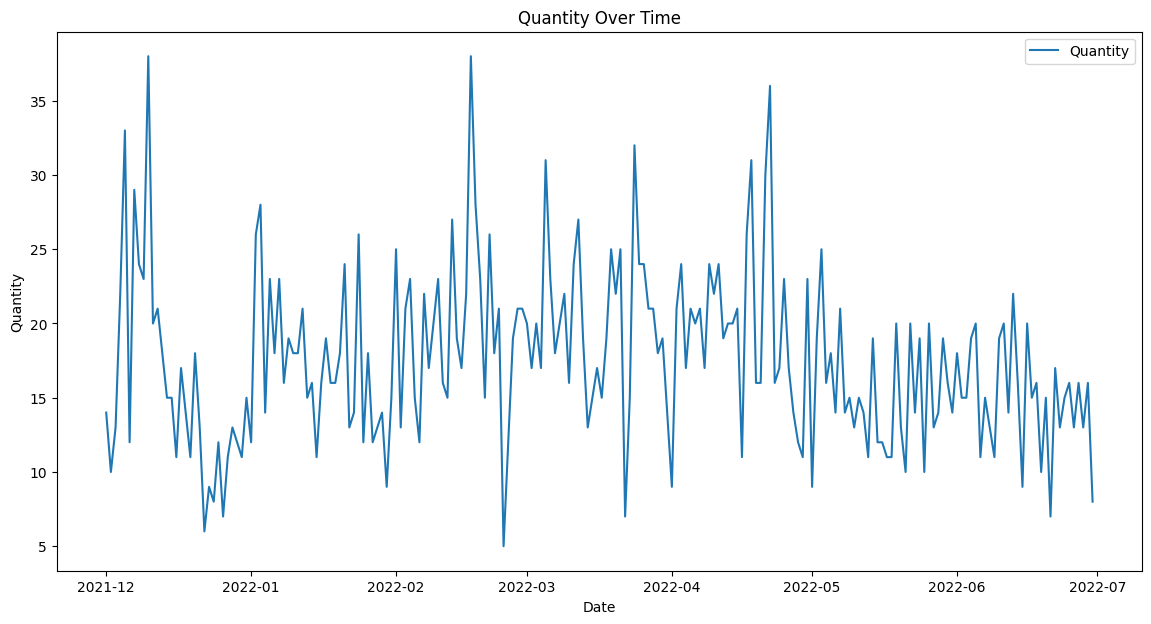

                            OLS Regression Results                            
Dep. Variable:               Quantity   R-squared:                       0.013
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     2.700
Date:                Mon, 15 Jul 2024   Prob (F-statistic):              0.102
Time:                        10:10:41   Log-Likelihood:                -671.28
No. Observations:                 212   AIC:                             1347.
Df Residuals:                     210   BIC:                             1353.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         18.6645      0.789     23.644      0.0

In [22]:
# Load dataset (assuming 'ProductA.xlsx' contains your sales data)
product_a_df = pd.read_excel('ProductA.xlsx')

# Assuming your data has a column representing time or dates, set it as index
product_a_df.set_index('Date', inplace=True)

# Convert index to datetime if it's not already in datetime format
product_a_df.index = pd.to_datetime(product_a_df.index)

# Plot the Quantity time series to visualize the trend
plt.figure(figsize=(14, 7))
plt.plot(product_a_df['Quantity'], label='Quantity')
plt.title('Quantity Over Time')
plt.xlabel('Date')
plt.ylabel('Quantity')
plt.legend()
plt.show()

# Perform linear regression to find the trend
X = sm.add_constant(range(len(product_a_df)))
y = product_a_df['Quantity']

model = sm.OLS(y, X).fit()

# Print the regression summary
print(model.summary())

# Interpret the trend
trend_coefficient = model.params[1]
if trend_coefficient > 0:
    print("There is a significant upward trend in the sales data.")
elif trend_coefficient < 0:
    print("There is a significant downward trend in the sales data.")
else:
    print("There is no significant trend in the sales data.")

Seasonlity

Duplicate columns: Index([], dtype='object')
Columns after removing duplicates: Index(['Date', 'Quantity', 'Clicks', 'Impressions'], dtype='object')


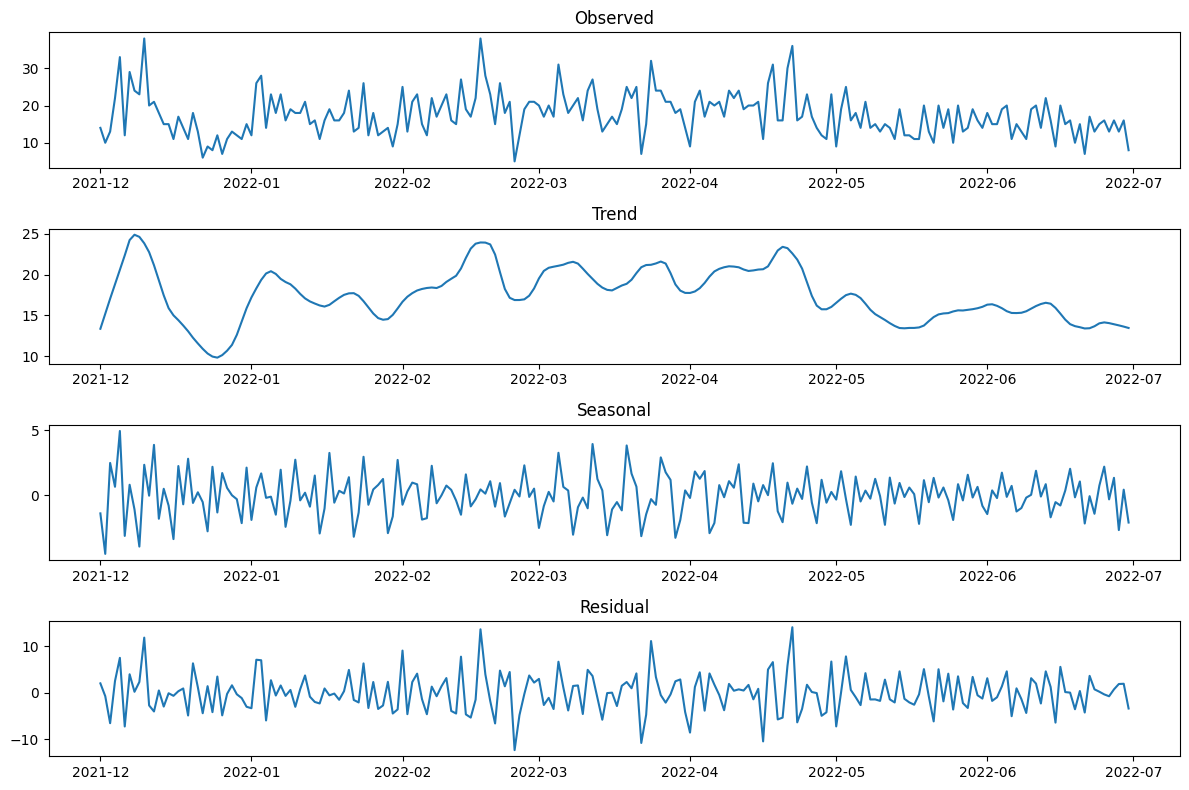

In [23]:
# Load Datasets
product_a_df = pd.read_excel('/content/ProductA.xlsx')
product_a_google_clicks_df = pd.read_excel('/content/ProductA_google_clicks.xlsx')
product_a_fb_impressions_df = pd.read_excel('/content/ProductA_fb_impressions.xlsx')

# Merge datasets based on 'Date'
merged_df = pd.merge(product_a_df, product_a_google_clicks_df, on='Date', how='left')
merged_df = pd.merge(merged_df, product_a_fb_impressions_df, on='Date', how='left')

# Check for duplicate columns
duplicate_columns = merged_df.columns[merged_df.columns.duplicated()].unique()
print("Duplicate columns:", duplicate_columns)

# Remove duplicate columns by keeping the first occurrence
merged_df = merged_df.loc[:, ~merged_df.columns.duplicated()]

# Verify removal
print("Columns after removing duplicates:", merged_df.columns)

# Convert 'Date' to datetime if it's not already in datetime format
merged_df['Date'] = pd.to_datetime(merged_df['Date'], errors='coerce')

# Drop rows with invalid dates
merged_df = merged_df.dropna(subset=['Date'])

# Set 'Date' as the index of the DataFrame
merged_df.set_index('Date', inplace=True)

# Decompose the 'Quantity' series using STL decomposition
stl = STL(merged_df['Quantity'], seasonal=13)
result = stl.fit()

# Plot the decomposed components
plt.figure(figsize=(12, 8))

plt.subplot(4, 1, 1)
plt.plot(result.observed)
plt.title('Observed')

plt.subplot(4, 1, 2)
plt.plot(result.trend)
plt.title('Trend')

plt.subplot(4, 1, 3)
plt.plot(result.seasonal)
plt.title('Seasonal')

plt.subplot(4, 1, 4)
plt.plot(result.resid)
plt.title('Residual')

plt.tight_layout()
plt.show()



Google Clicks Effect

Columns in merged_df:
Index(['Quantity', 'Clicks', 'Impressions'], dtype='object')


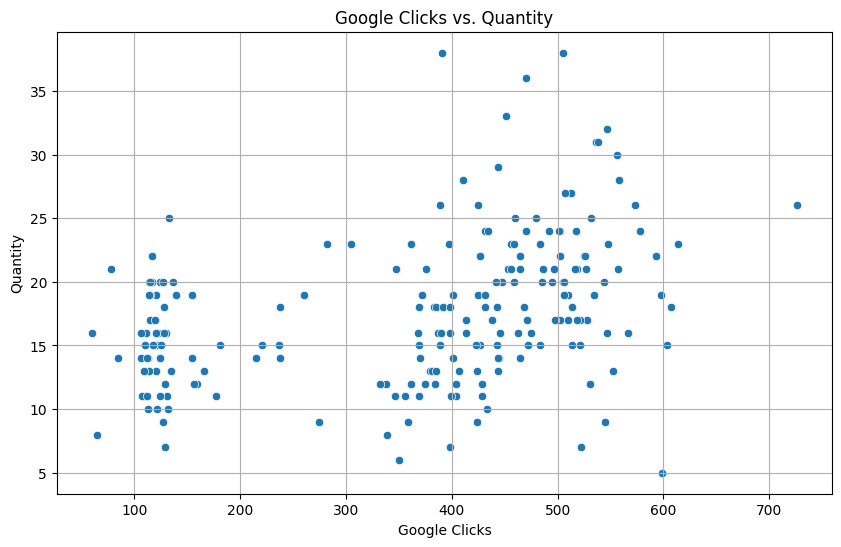

In [34]:
# Verify column names in merged_df
print("Columns in merged_df:")
print(merged_df.columns)

# Visualize the relationship between Google clicks and sales
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Clicks', y='Quantity', data=merged_df)
plt.title('Google Clicks vs. Quantity')
plt.xlabel('Google Clicks')
plt.ylabel('Quantity')
plt.grid(True)
plt.show()


Facebook Impressions Effect

Columns in merged_df:
Index(['Quantity', 'Clicks', 'Impressions'], dtype='object')


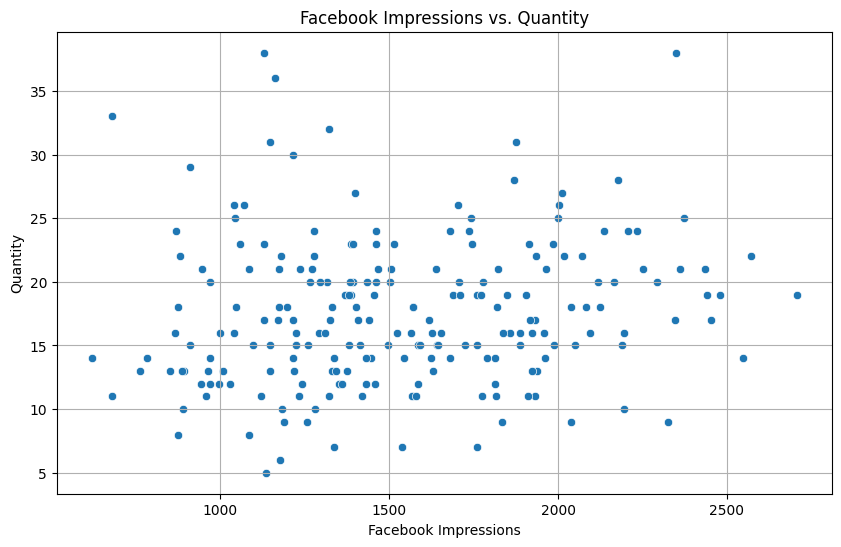

In [35]:
# Verify column names in merged_df
print("Columns in merged_df:")
print(merged_df.columns)

# Visualize the relationship between Facebook impressions and sales
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Impressions', y='Quantity', data=merged_df)
plt.title('Facebook Impressions vs. Quantity')
plt.xlabel('Facebook Impressions')
plt.ylabel('Quantity')
plt.grid(True)
plt.show()

Lagged Effects

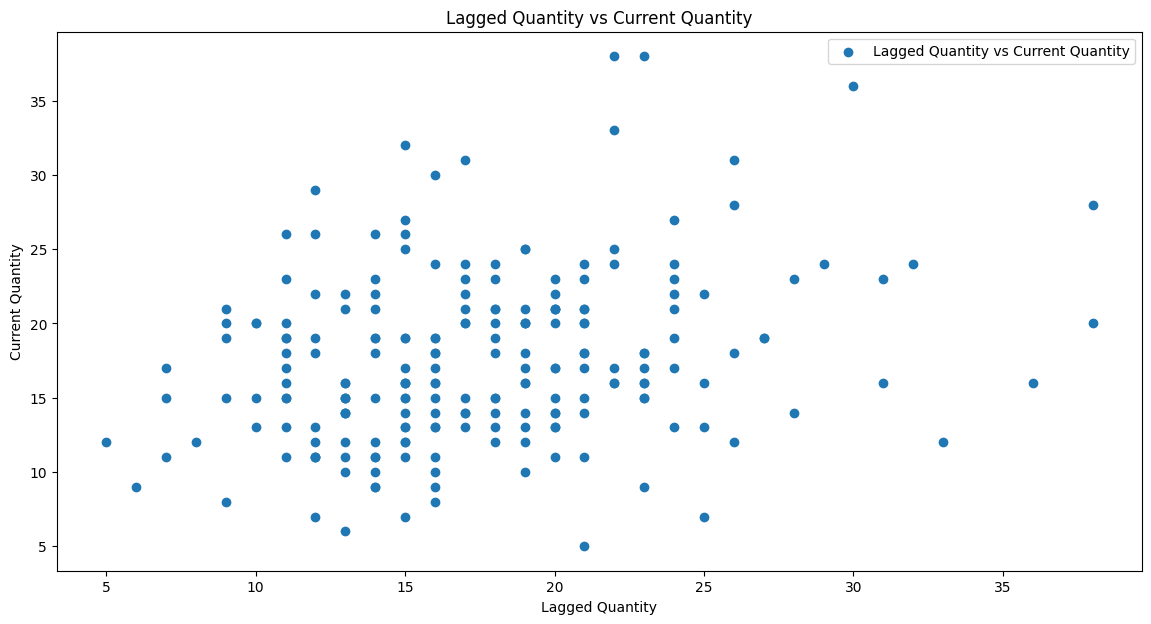

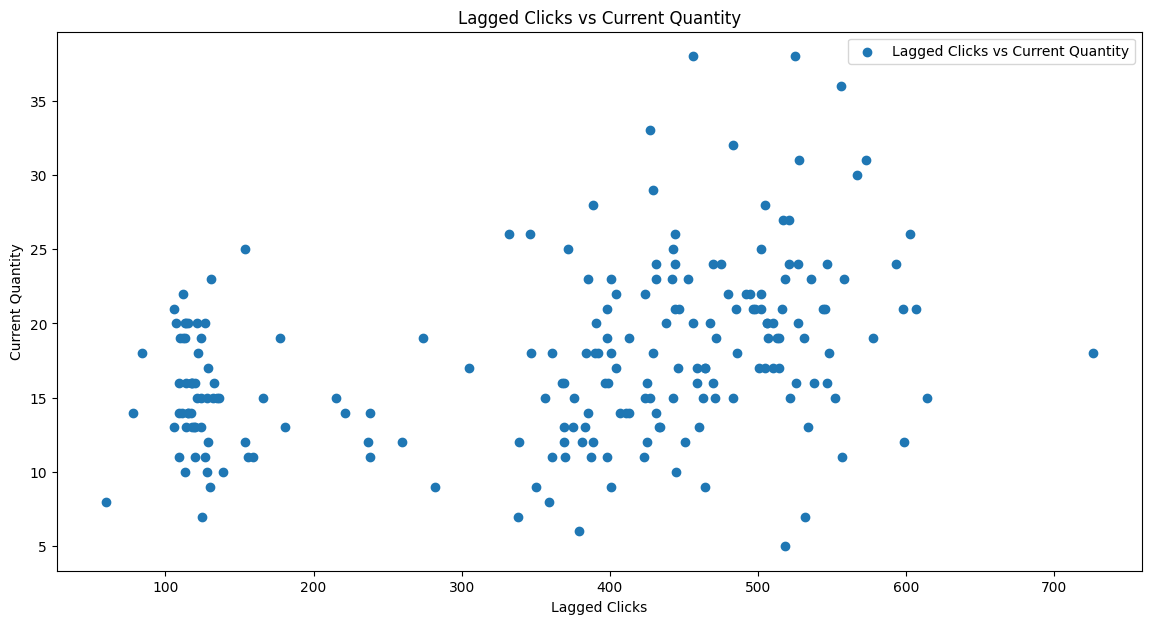

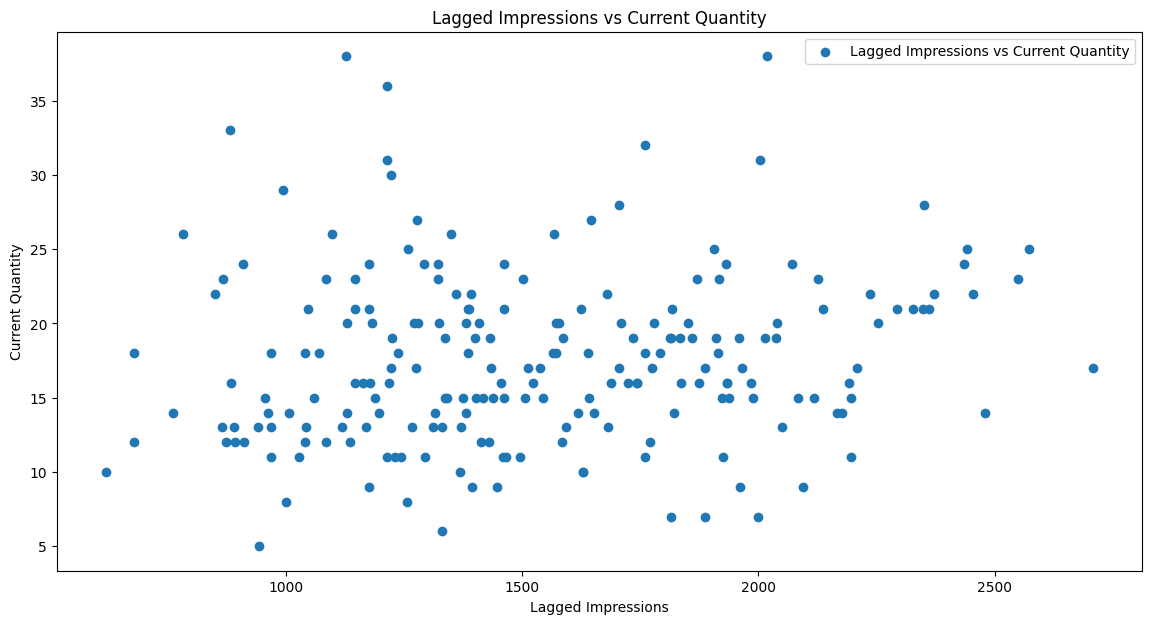

In [36]:
merged_df['Lagged_Quantity'] = merged_df['Quantity'].shift(1)
merged_df['Lagged_Clicks'] = merged_df['Clicks'].shift(1)
merged_df['Lagged_Impressions'] = merged_df['Impressions'].shift(1)

# Drop NaN rows introduced by shifting
merged_df.dropna(inplace=True)

# Scatter plot of Lagged Quantity vs Current Quantity
plt.figure(figsize=(14, 7))
plt.scatter(merged_df['Lagged_Quantity'], merged_df['Quantity'], label='Lagged Quantity vs Current Quantity')
plt.title('Lagged Quantity vs Current Quantity')
plt.xlabel('Lagged Quantity')
plt.ylabel('Current Quantity')
plt.legend()
plt.show()

# Scatter plot of Lagged Clicks vs Current Quantity
plt.figure(figsize=(14, 7))
plt.scatter(merged_df['Lagged_Clicks'], merged_df['Quantity'], label='Lagged Clicks vs Current Quantity')
plt.title('Lagged Clicks vs Current Quantity')
plt.xlabel('Lagged Clicks')
plt.ylabel('Current Quantity')
plt.legend()
plt.show()

# Scatter plot of Lagged Impressions vs Current Quantity
plt.figure(figsize=(14, 7))
plt.scatter(merged_df['Lagged_Impressions'], merged_df['Quantity'], label='Lagged Impressions vs Current Quantity')
plt.title('Lagged Impressions vs Current Quantity')
plt.xlabel('Lagged Impressions')
plt.ylabel('Current Quantity')
plt.legend()
plt.show()


Autocorrelation

<Figure size 1200x600 with 0 Axes>

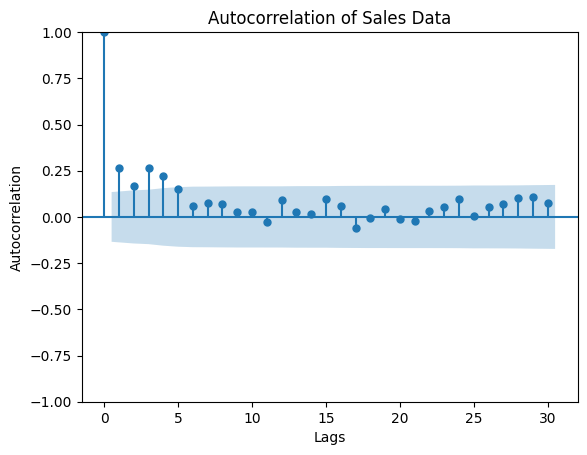

<Figure size 1200x600 with 0 Axes>

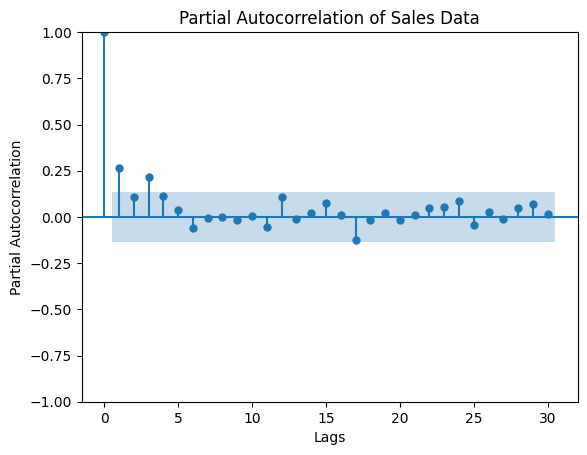

<Figure size 1200x600 with 0 Axes>

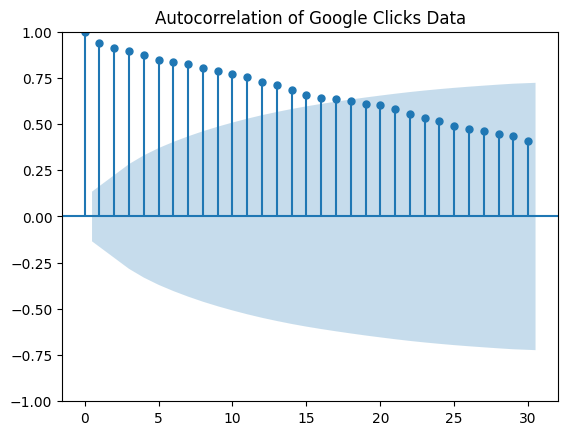

<Figure size 1200x600 with 0 Axes>

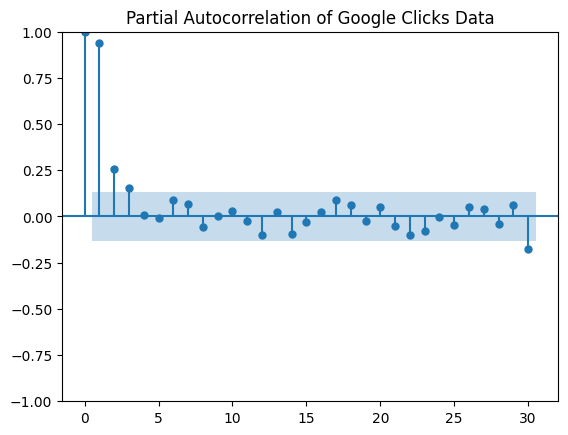

<Figure size 1200x600 with 0 Axes>

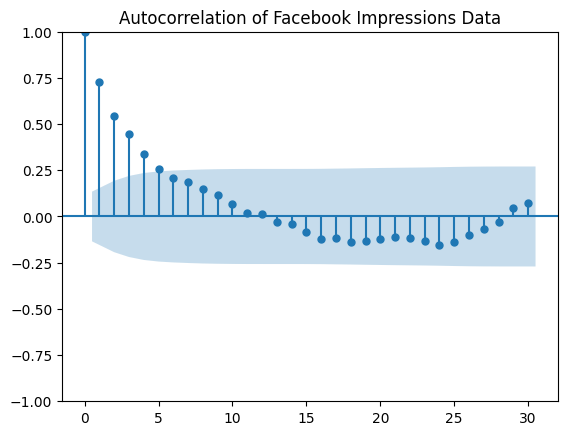

<Figure size 1200x600 with 0 Axes>

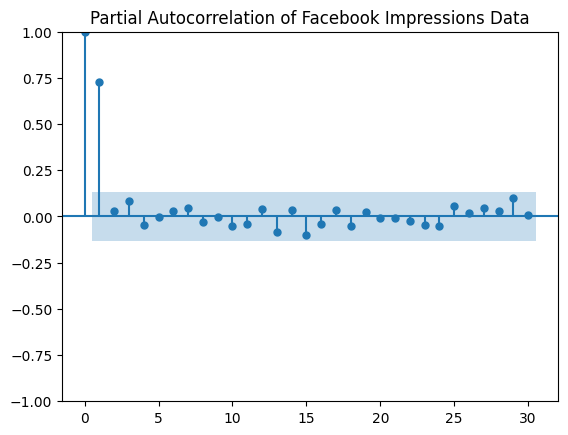

In [24]:
# Plot ACF for the 'Quantity' series
plt.figure(figsize=(12, 6))
plot_acf(merged_df['Quantity'].dropna(), lags=30)
plt.title('Autocorrelation of Sales Data')
plt.xlabel('Lags')
plt.ylabel('Autocorrelation')
plt.show()

# Plot PACF for the 'Quantity' series
plt.figure(figsize=(12, 6))
plot_pacf(merged_df['Quantity'].dropna(), lags=30)
plt.title('Partial Autocorrelation of Sales Data')
plt.xlabel('Lags')
plt.ylabel('Partial Autocorrelation')
plt.show()
# Plot autocorrelation and partial autocorrelation for sales data
plt.figure(figsize=(12, 6))
plot_acf(merged_df['Clicks'], lags=30)
plt.title('Autocorrelation of Google Clicks Data')
plt.show()

plt.figure(figsize=(12, 6))
plot_pacf(merged_df['Clicks'], lags=30)
plt.title('Partial Autocorrelation of Google Clicks Data')
plt.show()
# Plot autocorrelation and partial autocorrelation for sales data
plt.figure(figsize=(12, 6))
plot_acf(merged_df['Impressions'], lags=30)
plt.title('Autocorrelation of Facebook Impressions Data')
plt.show()

plt.figure(figsize=(12, 6))
plot_pacf(merged_df['Impressions'], lags=30)
plt.title('Partial Autocorrelation of Facebook Impressions Data')
plt.show()

Training and Testing

In [25]:
# Split the data into training (80%) and temp (20%) sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)

# Further split temp into validation (50% of 20% = 10% of total) and testing (50% of 20% = 10% of total) sets
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Fit the model on the training set
model = sm.OLS(y_train, sm.add_constant(X_train)).fit()

# Predict on the training, validation, and testing sets
y_train_pred = model.predict(sm.add_constant(X_train))
y_val_pred = model.predict(sm.add_constant(X_val))
y_test_pred = model.predict(sm.add_constant(X_test))

# Calculate MAPE for training, validation, and testing sets
mape_train = mean_absolute_percentage_error(y_train, y_train_pred)
mape_val = mean_absolute_percentage_error(y_val, y_val_pred)
mape_test = mean_absolute_percentage_error(y_test, y_test_pred)

# Print the length of each set and MAPE values
print(f"Length of Training Set: {len(X_train)}")
print(f"Length of Validation Set: {len(X_val)}")
print(f"Length of Testing Set: {len(X_test)}\n")

print(f"MAPE for Training Set: {mape_train:.4f}")
print(f"MAPE for Validation Set: {mape_val:.4f}")
print(f"MAPE for Testing Set: {mape_test:.4f}")

Length of Training Set: 169
Length of Validation Set: 21
Length of Testing Set: 22

MAPE for Training Set: 0.2947
MAPE for Validation Set: 0.3419
MAPE for Testing Set: 0.3697


AR

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dat

AR Model - Test Data: RMSE: 4.7856723698638985, MAE: 3.9332465029852632, MAPE: 33.36796332555598
AR Model - Validation Data: RMSE: 5.946204298802739, MAE: 4.782016824581227, MAPE: 29.264468955776135


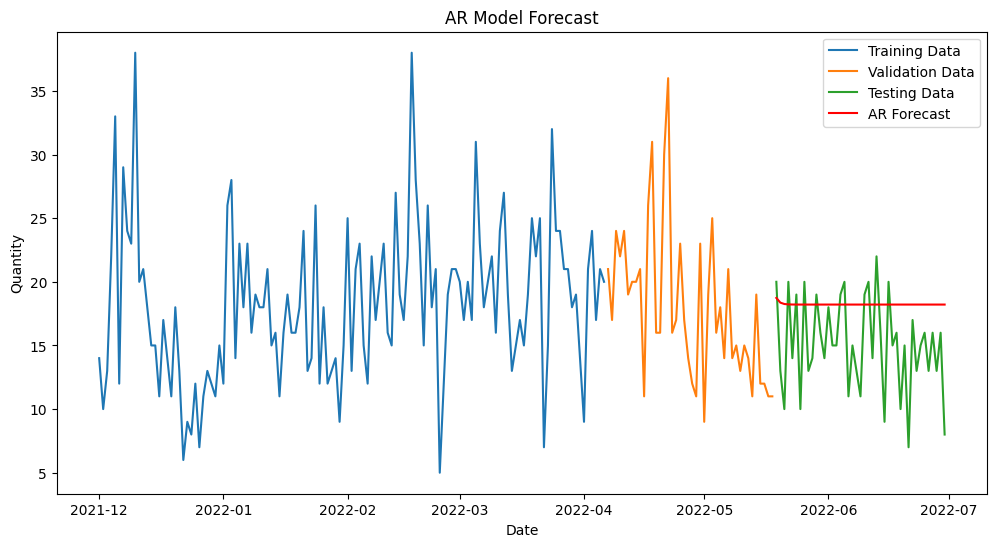

In [26]:
# Assuming merged_df is your DataFrame and is already loaded
# Ensure the data is sorted by date
merged_df = merged_df.sort_index()

# Split the data into training (60%), validation (20%), and testing (20%) sets
train_size = int(len(merged_df) * 0.6)
validation_size = int(len(merged_df) * 0.2)
test_size = len(merged_df) - train_size - validation_size

train_set = merged_df.iloc[:train_size]
validation_set = merged_df.iloc[train_size:train_size + validation_size]
test_set = merged_df.iloc[train_size + validation_size:]

# Define a function to calculate MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Extract the target variable
train_target = train_set['Quantity']
test_target = test_set['Quantity']
validation_target = validation_set['Quantity']

# Define the function to fit and forecast using ARIMA
def fit_and_forecast_arima(train, order, steps):
    model = ARIMA(train, order=order)
    model_fit = model.fit()
    forecast = model_fit.forecast(steps=steps)
    return model_fit, forecast

# AR model
ar_order = (1, 0, 0)
ar_model, ar_forecast_test = fit_and_forecast_arima(train_target, ar_order, len(test_target))
_, ar_forecast_validation = fit_and_forecast_arima(train_target, ar_order, len(validation_target))

# Calculate metrics
def calculate_metrics(true_values, predictions):
    rmse = np.sqrt(mean_squared_error(true_values, predictions))
    mae = mean_absolute_error(true_values, predictions)
    mape = mean_absolute_percentage_error(true_values, predictions)
    return rmse, mae, mape

# AR model metrics
ar_rmse_test, ar_mae_test, ar_mape_test = calculate_metrics(test_target, ar_forecast_test)
ar_rmse_validation, ar_mae_validation, ar_mape_validation = calculate_metrics(validation_target, ar_forecast_validation)

# Print the metrics
print(f"AR Model - Test Data: RMSE: {ar_rmse_test}, MAE: {ar_mae_test}, MAPE: {ar_mape_test}")
print(f"AR Model - Validation Data: RMSE: {ar_rmse_validation}, MAE: {ar_mae_validation}, MAPE: {ar_mape_validation}")

# Plot the observed vs forecast for test data
plt.figure(figsize=(12, 6))
plt.plot(train_set.index, train_set['Quantity'], label='Training Data')
plt.plot(validation_set.index, validation_set['Quantity'], label='Validation Data')
plt.plot(test_set.index, test_set['Quantity'], label='Testing Data')
plt.plot(test_set.index, ar_forecast_test, label='AR Forecast', color='red')
plt.title('AR Model Forecast')
plt.xlabel('Date')
plt.ylabel('Quantity')
plt.legend()
plt.show()


MA

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dat

MA Model - Test Data: RMSE: 4.786153042270043, MAE: 3.93869688228558, MAPE: 33.393528411010784
MA Model - Validation Data: RMSE: 5.949730228423728, MAE: 4.787626155146834, MAPE: 29.29726026790304


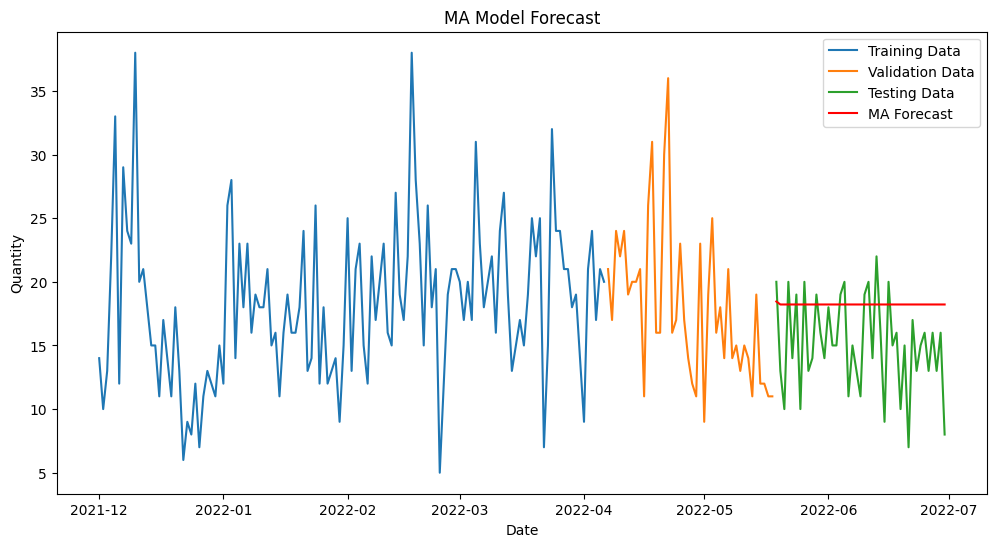

In [27]:
# Assuming merged_df is your DataFrame and is already loaded
# Ensure the data is sorted by date
merged_df = merged_df.sort_index()

# Split the data into training (60%), validation (20%), and testing (20%) sets
train_size = int(len(merged_df) * 0.6)
validation_size = int(len(merged_df) * 0.2)
test_size = len(merged_df) - train_size - validation_size

train_set = merged_df.iloc[:train_size]
validation_set = merged_df.iloc[train_size:train_size + validation_size]
test_set = merged_df.iloc[train_size + validation_size:]

# Define a function to calculate MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Extract the target variable
train_target = train_set['Quantity']
test_target = test_set['Quantity']
validation_target = validation_set['Quantity']

# Define the function to fit and forecast using ARIMA (for MA)
def fit_and_forecast_arima(train, order, steps):
    model = ARIMA(train, order=order)
    model_fit = model.fit()
    forecast = model_fit.forecast(steps=steps)
    return model_fit, forecast

# MA model
ma_order = (0, 0, 1)
ma_model, ma_forecast_test = fit_and_forecast_arima(train_target, ma_order, len(test_target))
_, ma_forecast_validation = fit_and_forecast_arima(train_target, ma_order, len(validation_target))

# Calculate metrics
def calculate_metrics(true_values, predictions):
    rmse = np.sqrt(mean_squared_error(true_values, predictions))
    mae = mean_absolute_error(true_values, predictions)
    mape = mean_absolute_percentage_error(true_values, predictions)
    return rmse, mae, mape

# MA model metrics
ma_rmse_test, ma_mae_test, ma_mape_test = calculate_metrics(test_target, ma_forecast_test)
ma_rmse_validation, ma_mae_validation, ma_mape_validation = calculate_metrics(validation_target, ma_forecast_validation)

# Print the metrics
print(f"MA Model - Test Data: RMSE: {ma_rmse_test}, MAE: {ma_mae_test}, MAPE: {ma_mape_test}")
print(f"MA Model - Validation Data: RMSE: {ma_rmse_validation}, MAE: {ma_mae_validation}, MAPE: {ma_mape_validation}")

# Plot the observed vs forecast for test data
plt.figure(figsize=(12, 6))
plt.plot(train_set.index, train_set['Quantity'], label='Training Data')
plt.plot(validation_set.index, validation_set['Quantity'], label='Validation Data')
plt.plot(test_set.index, test_set['Quantity'], label='Testing Data')
plt.plot(test_set.index, ma_forecast_test, label='MA Forecast', color='red')
plt.title('MA Model Forecast')
plt.xlabel('Date')
plt.ylabel('Quantity')
plt.legend()
plt.show()


Arima

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dat

ARIMA Model - Test Data: RMSE: 4.80870594790157, MAE: 3.9337291096439713, MAPE: 33.43616548565122
ARIMA Model - Validation Data: RMSE: 5.9204186659749025, MAE: 4.746750557674151, MAPE: 29.086040149327424


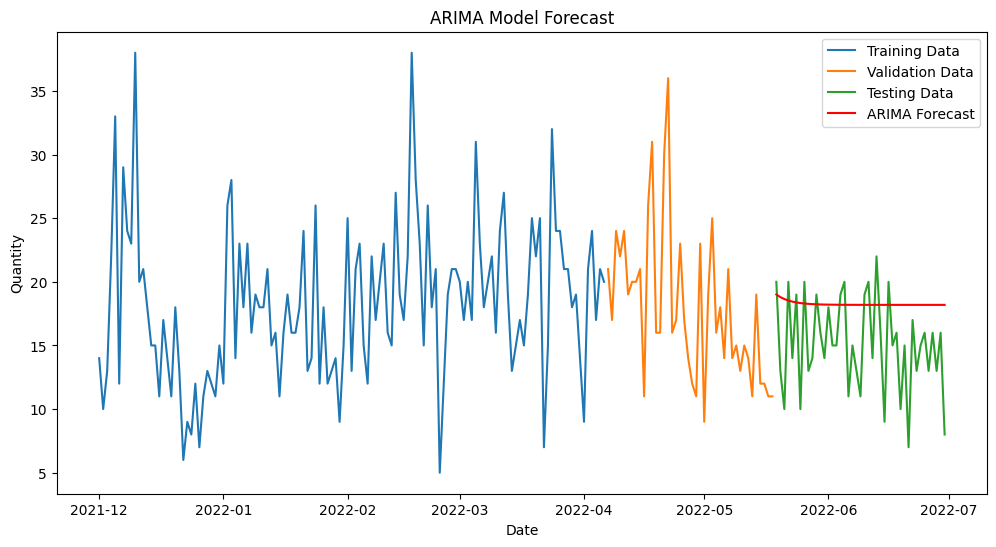

In [28]:
# Assuming merged_df is your DataFrame and is already loaded
# Ensure the data is sorted by date
merged_df = merged_df.sort_index()

# Split the data into training (60%), validation (20%), and testing (20%) sets
train_size = int(len(merged_df) * 0.6)
validation_size = int(len(merged_df) * 0.2)
test_size = len(merged_df) - train_size - validation_size

train_set = merged_df.iloc[:train_size]
validation_set = merged_df.iloc[train_size:train_size + validation_size]
test_set = merged_df.iloc[train_size + validation_size:]

# Define a function to calculate MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Extract the target variable
train_target = train_set['Quantity']
test_target = test_set['Quantity']
validation_target = validation_set['Quantity']

# Define the function to fit and forecast using ARIMA
def fit_and_forecast_arima(train, order, steps):
    model = ARIMA(train, order=order)
    model_fit = model.fit()
    forecast = model_fit.forecast(steps=steps)
    return model_fit, forecast

# ARIMA model
arima_order = (1, 0, 1)  # Adjust the order (p, d, q) based on your analysis
arima_model, arima_forecast_test = fit_and_forecast_arima(train_target, arima_order, len(test_target))
_, arima_forecast_validation = fit_and_forecast_arima(train_target, arima_order, len(validation_target))

# Calculate metrics
def calculate_metrics(true_values, predictions):
    rmse = np.sqrt(mean_squared_error(true_values, predictions))
    mae = mean_absolute_error(true_values, predictions)
    mape = mean_absolute_percentage_error(true_values, predictions)
    return rmse, mae, mape

# ARIMA model metrics
arima_rmse_test, arima_mae_test, arima_mape_test = calculate_metrics(test_target, arima_forecast_test)
arima_rmse_validation, arima_mae_validation, arima_mape_validation = calculate_metrics(validation_target, arima_forecast_validation)

# Print the metrics
print(f"ARIMA Model - Test Data: RMSE: {arima_rmse_test}, MAE: {arima_mae_test}, MAPE: {arima_mape_test}")
print(f"ARIMA Model - Validation Data: RMSE: {arima_rmse_validation}, MAE: {arima_mae_validation}, MAPE: {arima_mape_validation}")

# Plot the observed vs forecast for test data
plt.figure(figsize=(12, 6))
plt.plot(train_set.index, train_set['Quantity'], label='Training Data')
plt.plot(validation_set.index, validation_set['Quantity'], label='Validation Data')
plt.plot(test_set.index, test_set['Quantity'], label='Testing Data')
plt.plot(test_set.index, arima_forecast_test, label='ARIMA Forecast', color='red')
plt.title('ARIMA Model Forecast')
plt.xlabel('Date')
plt.ylabel('Quantity')
plt.legend()
plt.show()


Arimax

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dat

ARIMAX Model - Validation Data: RMSE: 5.84620285599446, MAE: 4.315453539687149, MAPE: 22.744851079561702
ARIMAX Model - Test Data: RMSE: 4.180226849247272, MAE: 3.42355770292223, MAPE: 22.786572047688935


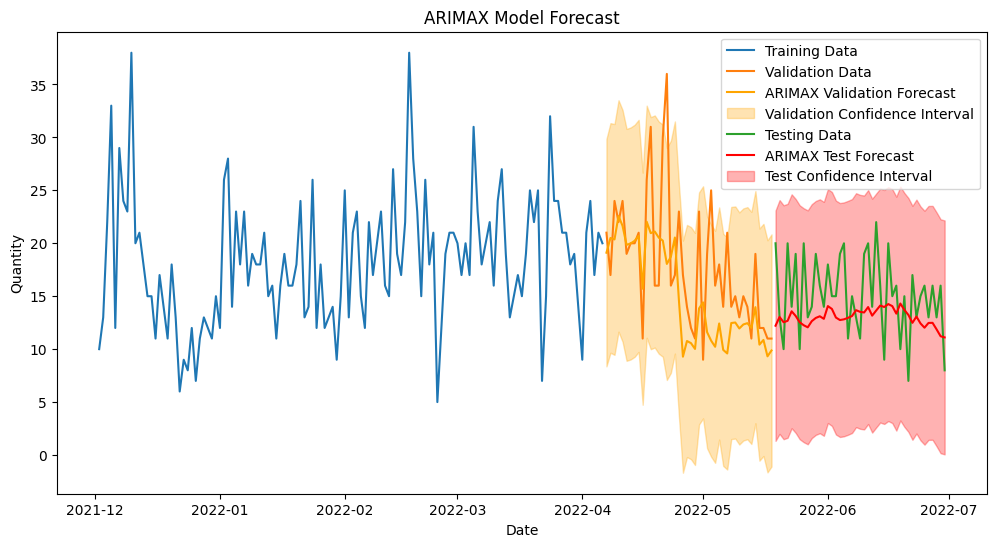

In [39]:
# Ensure the data is sorted by date
merged_df = merged_df.sort_index()

# Split the data into training (60%), validation (20%), and testing (20%) sets
train_size = int(len(merged_df) * 0.6)
validation_size = int(len(merged_df) * 0.2)
test_size = len(merged_df) - train_size - validation_size

train_set = merged_df.iloc[:train_size]
validation_set = merged_df.iloc[train_size:train_size + validation_size]
test_set = merged_df.iloc[train_size + validation_size:]

# Define a function to calculate MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Extract the target variable
train_target = train_set['Quantity']
validation_target = validation_set['Quantity']
test_target = test_set['Quantity']

# Define the function to fit and forecast using ARIMA
def fit_and_forecast_arima(train, order, steps):
    model = ARIMA(train, order=order)
    model_fit = model.fit()
    forecast = model_fit.forecast(steps=steps)
    return model_fit, forecast



# ARIMAX model
arimax_order = (1, 0, 1)  # Adjust the order (p, d, q) based on your analysis
arimax_model, arimax_forecast_validation = fit_and_forecast_arimax(train_target, exog_train, exog_validation, arimax_order, len(validation_target))
_, arimax_forecast_test = fit_and_forecast_arimax(pd.concat([train_target, validation_target]), pd.concat([exog_train, exog_validation]), exog_test, arimax_order, len(test_target))

# Extract forecasted values and confidence intervals for validation and test sets
arimax_forecast_validation_mean = arimax_forecast_validation.predicted_mean
arimax_forecast_validation_ci = arimax_forecast_validation.conf_int()
arimax_forecast_test_mean = arimax_forecast_test.predicted_mean
arimax_forecast_test_ci = arimax_forecast_test.conf_int()

# Calculate metrics for ARIMAX
arimax_rmse_validation, arimax_mae_validation, arimax_mape_validation = calculate_metrics(validation_target, arimax_forecast_validation_mean)
arimax_rmse_test, arimax_mae_test, arimax_mape_test = calculate_metrics(test_target, arimax_forecast_test_mean)

# Print the metrics
print(f"ARIMAX Model - Validation Data: RMSE: {arimax_rmse_validation}, MAE: {arimax_mae_validation}, MAPE: {arimax_mape_validation}")
print(f"ARIMAX Model - Test Data: RMSE: {arimax_rmse_test}, MAE: {arimax_mae_test}, MAPE: {arimax_mape_test}")

# Plot the observed vs forecast for validation and test data
plt.figure(figsize=(12, 6))
plt.plot(train_set.index, train_set['Quantity'], label='Training Data')
plt.plot(validation_set.index, validation_set['Quantity'], label='Validation Data')
plt.plot(validation_set.index, arimax_forecast_validation_mean, label='ARIMAX Validation Forecast', color='orange')
plt.fill_between(arimax_forecast_validation_ci.index, arimax_forecast_validation_ci.iloc[:, 0], arimax_forecast_validation_ci.iloc[:, 1], color='orange', alpha=0.3, label='Validation Confidence Interval')
plt.plot(test_set.index, test_set['Quantity'], label='Testing Data')
plt.plot(test_set.index, arimax_forecast_test_mean, label='ARIMAX Test Forecast', color='red')
plt.fill_between(arimax_forecast_test_ci.index, arimax_forecast_test_ci.iloc[:, 0], arimax_forecast_test_ci.iloc[:, 1], color='red', alpha=0.3, label='Test Confidence Interval')
plt.title('ARIMAX Model Forecast')
plt.xlabel('Date')
plt.ylabel('Quantity')
plt.legend()
plt.show()


Sarimax

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


                                     SARIMAX Results                                      
Dep. Variable:                           Quantity   No. Observations:                  127
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 12)   Log Likelihood                -408.627
Date:                            Mon, 15 Jul 2024   AIC                            827.254
Time:                                    10:11:04   BIC                            841.475
Sample:                                12-01-2021   HQIC                           833.032
                                     - 04-06-2022                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9974      0.006    164.808      0.000       0.986       1.009
ma.L1         -0.7632      0.078   

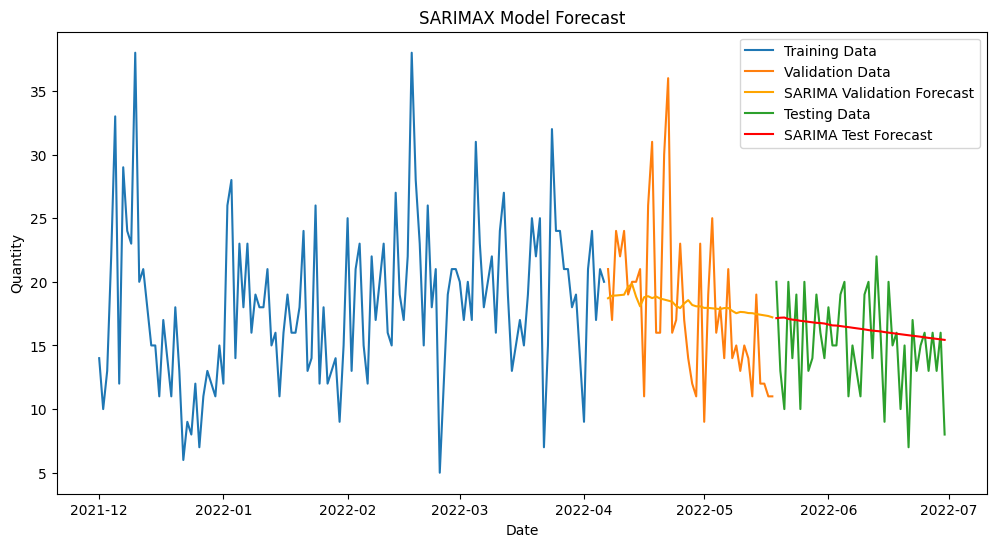

In [30]:
# Ensure the data is sorted by date
merged_df = merged_df.sort_index()

# Split the data into training (60%), validation (20%), and testing (20%) sets
train_size = int(len(merged_df) * 0.6)
validation_size = int(len(merged_df) * 0.2)
test_size = len(merged_df) - train_size - validation_size

train_set = merged_df.iloc[:train_size]
validation_set = merged_df.iloc[train_size:train_size + validation_size]
test_set = merged_df.iloc[train_size + validation_size:]

# Define a function to calculate MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Extract the target variable
train_target = train_set['Quantity']
validation_target = validation_set['Quantity']
test_target = test_set['Quantity']

# Define and fit SARIMA model on the training set
p = 1   # AutoRegressive (AR) order
d = 0   # Integrated (I) order (no differencing)
q = 1   # Moving Average (MA) order
P = 1   # Seasonal AutoRegressive (SAR) order
D = 0   # Seasonal Integrated (SI) order (no seasonal differencing)
Q = 1   # Seasonal Moving Average (SMA) order
seasonal_period = 12  # Seasonal period (assuming monthly data)

sarima_model = SARIMAX(train_target, order=(p, d, q), seasonal_order=(P, D, Q, seasonal_period))
sarima_fit = sarima_model.fit()

# Summary of the SARIMA model
print(sarima_fit.summary())

# Predict on the validation set
sarima_forecast_validation = sarima_fit.predict(start=validation_set.index[0], end=validation_set.index[-1], dynamic=False)

# Predict on the test set
sarima_forecast_test = sarima_fit.predict(start=test_set.index[0], end=test_set.index[-1], dynamic=False)

# Calculate metrics
def calculate_metrics(true_values, predictions):
    rmse = np.sqrt(mean_squared_error(true_values, predictions))
    mae = mean_absolute_error(true_values, predictions)
    mape = mean_absolute_percentage_error(true_values, predictions)
    return rmse, mae, mape

# SARIMA model metrics for validation set
sarima_rmse_validation, sarima_mae_validation, sarima_mape_validation = calculate_metrics(validation_target, sarima_forecast_validation)

# SARIMA model metrics for test set
sarima_rmse_test, sarima_mae_test, sarima_mape_test = calculate_metrics(test_target, sarima_forecast_test)

# Print the metrics
print(f"SARIMAX Model - Validation Data: RMSE: {sarima_rmse_validation}, MAE: {sarima_mae_validation}, MAPE: {sarima_mape_validation}")
print(f"SARIMAX Model - Test Data: RMSE: {sarima_rmse_test}, MAE: {sarima_mae_test}, MAPE: {sarima_mape_test}")

# Plot the observed vs forecast for validation and test data
plt.figure(figsize=(12, 6))
plt.plot(train_set.index, train_set['Quantity'], label='Training Data')
plt.plot(validation_set.index, validation_set['Quantity'], label='Validation Data')
plt.plot(validation_set.index, sarima_forecast_validation, label='SARIMA Validation Forecast', color='orange')
plt.plot(test_set.index, test_set['Quantity'], label='Testing Data')
plt.plot(test_set.index, sarima_forecast_test, label='SARIMA Test Forecast', color='red')
plt.title('SARIMAX Model Forecast')
plt.xlabel('Date')
plt.ylabel('Quantity')
plt.legend()
plt.show()


Multivarient Linear regression


Linear Regression Model - Validation Data: RMSE: 5.877141080959961, MAE: 4.3616402216120145, MAPE: 23.077677865817588
Linear Regression Model - Test Data: RMSE: 6.312731777974665, MAE: 5.479579362938303, MAPE: 33.602128810475946


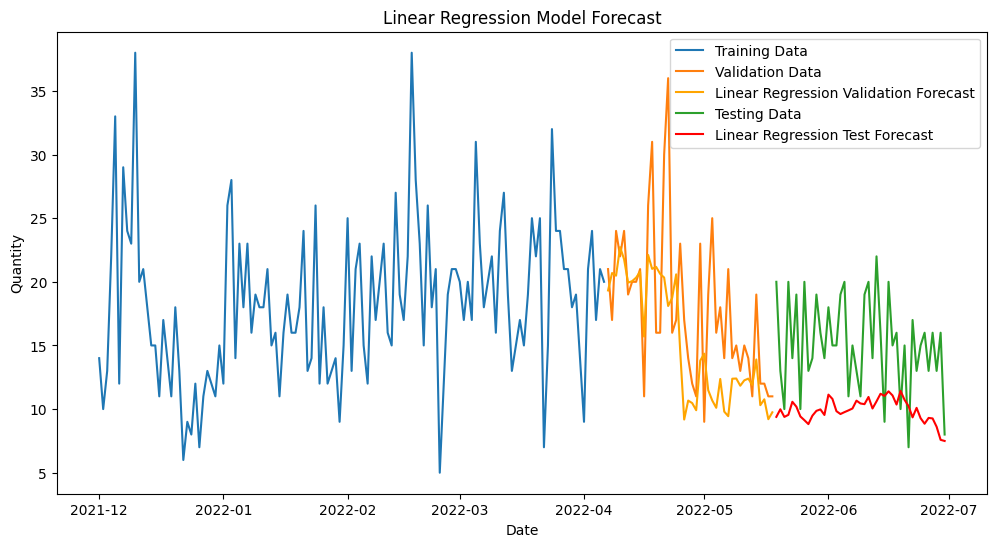

In [31]:
# Ensure the data is sorted by date
merged_df = merged_df.sort_index()

# Split the data into training (60%), validation (20%), and testing (20%) sets
train_size = int(len(merged_df) * 0.6)
validation_size = int(len(merged_df) * 0.2)
test_size = len(merged_df) - train_size - validation_size

train_set = merged_df.iloc[:train_size]
validation_set = merged_df.iloc[train_size:train_size + validation_size]
test_set = merged_df.iloc[train_size + validation_size:]

# Define a function to calculate MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Extract the features and target variable
features = ['Clicks', 'Impressions']
target = 'Quantity'

train_features = train_set[features]
validation_features = validation_set[features]
test_features = test_set[features]

train_target = train_set[target]
validation_target = validation_set[target]
test_target = test_set[target]

# Fit the multivariate linear regression model
linear_model = LinearRegression()
linear_model.fit(train_features, train_target)

# Predict on the validation set
linear_forecast_validation = linear_model.predict(validation_features)

# Predict on the test set
linear_forecast_test = linear_model.predict(test_features)

# Calculate metrics
def calculate_metrics(true_values, predictions):
    rmse = np.sqrt(mean_squared_error(true_values, predictions))
    mae = mean_absolute_error(true_values, predictions)
    mape = mean_absolute_percentage_error(true_values, predictions)
    return rmse, mae, mape

# Linear regression model metrics for validation set
linear_rmse_validation, linear_mae_validation, linear_mape_validation = calculate_metrics(validation_target, linear_forecast_validation)

# Linear regression model metrics for test set
linear_rmse_test, linear_mae_test, linear_mape_test = calculate_metrics(test_target, linear_forecast_test)

# Print the metrics
print(f"Linear Regression Model - Validation Data: RMSE: {linear_rmse_validation}, MAE: {linear_mae_validation}, MAPE: {linear_mape_validation}")
print(f"Linear Regression Model - Test Data: RMSE: {linear_rmse_test}, MAE: {linear_mae_test}, MAPE: {linear_mape_test}")

# Plot the observed vs forecast for validation and test data
plt.figure(figsize=(12, 6))
plt.plot(train_set.index, train_set['Quantity'], label='Training Data')
plt.plot(validation_set.index, validation_set['Quantity'], label='Validation Data')
plt.plot(validation_set.index, linear_forecast_validation, label='Linear Regression Validation Forecast', color='orange')
plt.plot(test_set.index, test_set['Quantity'], label='Testing Data')
plt.plot(test_set.index, linear_forecast_test, label='Linear Regression Test Forecast', color='red')
plt.title('Linear Regression Model Forecast')
plt.xlabel('Date')
plt.ylabel('Quantity')
plt.legend()
plt.show()


Model Metrics


,Model,R2_Test,Adj_R2_Test,R2_Validation,Adj_R2_Validation
0,AR Model,-0.741099,-0.783565,0.000667,-0.024316
1,MA Model,-0.741449,-0.783923,-0.000518,-0.025531
2,ARIMA Model,-0.585429,-0.624098,0.008751,-0.016030
3,ARIMAX Model,-0.328426,-0.394847,0.033998,-0.015541
4,SARIMAX Model,-0.073903,-0.100096,0.083024,0.060100
5,Linear Regression Model,-2.029509,-2.180985,0.023746,-0.026318


Test Data Metrics
+----+---------------+---------+---------+---------+
|    | Model         |    RMSE |     MAE |    MAPE |
+====+===============+=========+=========+=========+
|  0 | AR Model      | 4.78567 | 3.93325 | 33.368  |
+----+---------------+---------+---------+---------+
|  1 | MA Model      | 4.78615 | 3.9387  | 33.3935 |
+----+---------------+---------+---------+---------+
|  2 | ARIMA Model   | 4.80871 | 3.93373 | 33.4362 |
+----+---------------+---------+---------+---------+
|  3 | ARIMAX Model  | 4.18023 | 3.42356 | 22.7866 |
+----+---------------+---------+---------+---------+
|  4 | SARIMAX Model | 3.88504 | 3.14354 | 26.0103 |
+----+---------------+---------+---------+---------+

Validation Data Metrics
+----+---------------+---------+---------+---------+
|    | Model         |    RMSE |     MAE |    MAPE |
+====+===============+=========+=========+=========+
|  0 | AR Model      | 5.9462  | 4.78202 | 29.2645 |
+----+---------------+---------+---------+---------+
|  

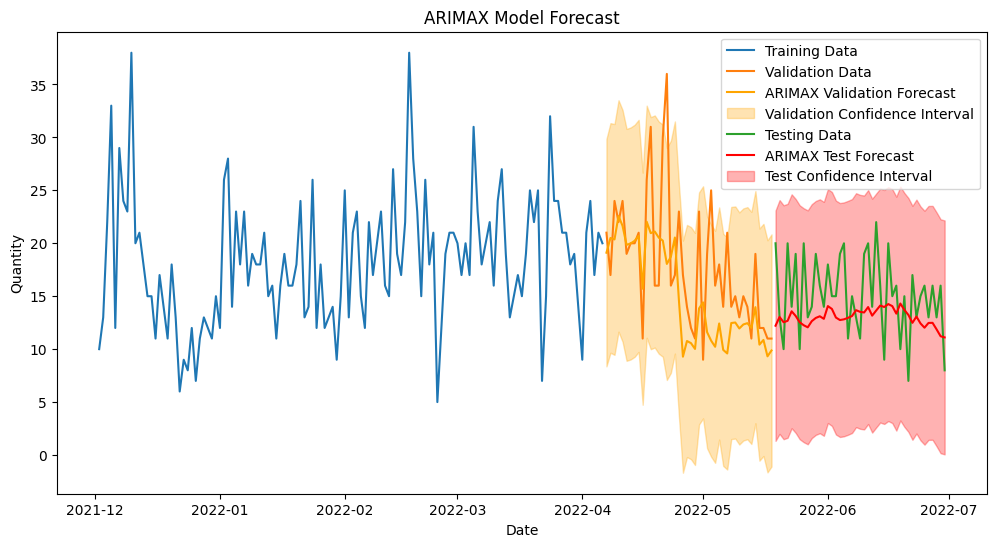

In [41]:
# Function to calculate R-squared and Adjusted R-squared
def calculate_r2_and_adj_r2(true_values, predictions, n_features):
    r2 = r2_score(true_values, predictions)
    n = len(true_values)
    adj_r2 = 1 - (1 - r2) * (n - 1) / (n - n_features - 1)
    return r2, adj_r2

# Calculate R-squared and Adjusted R-squared for all models
metrics = {
    'Model': ['AR Model', 'MA Model', 'ARIMA Model', 'ARIMAX Model', 'SARIMAX Model', 'Linear Regression Model'],
    'R2_Test': [],
    'Adj_R2_Test': [],
    'R2_Validation': [],
    'Adj_R2_Validation': []
}

# Extract forecast values from PredictionResultsWrapper
def extract_forecast(forecast):
    if hasattr(forecast, 'predicted_mean'):
        return forecast.predicted_mean
    elif hasattr(forecast, 'forecast'):
        return forecast.forecast
    else:
        return forecast

for forecast_test, forecast_validation, model_name, n_features in [
    (extract_forecast(ar_forecast_test), extract_forecast(ar_forecast_validation), 'AR Model', 1),
    (extract_forecast(ma_forecast_test), extract_forecast(ma_forecast_validation), 'MA Model', 1),
    (extract_forecast(arima_forecast_test), extract_forecast(arima_forecast_validation), 'ARIMA Model', 1),
    (extract_forecast(arimax_forecast_test), extract_forecast(arimax_forecast_validation), 'ARIMAX Model', 2),
    (extract_forecast(sarima_forecast_test), extract_forecast(sarima_forecast_validation), 'SARIMAX Model', 1),
    (linear_forecast_test, linear_forecast_validation, 'Linear Regression Model', len(features))
]:
    r2_test, adj_r2_test = calculate_r2_and_adj_r2(test_target, forecast_test, n_features)
    r2_val, adj_r2_val = calculate_r2_and_adj_r2(validation_target, forecast_validation, n_features)

    metrics['R2_Test'].append(r2_test)
    metrics['Adj_R2_Test'].append(adj_r2_test)
    metrics['R2_Validation'].append(r2_val)
    metrics['Adj_R2_Validation'].append(adj_r2_val)

# Create DataFrame and display results
df_metrics = pd.DataFrame(metrics)
print("Model Metrics")
display(df_metrics)

import pandas as pd
from tabulate import tabulate

# Data for test and validation metrics
data_test = {
    'Model': ['AR Model', 'MA Model', 'ARIMA Model', 'ARIMAX Model', 'SARIMAX Model'],
    'RMSE': [4.7856723698638985, 4.786153042270043, 4.80870594790157, 4.180226849247272, 3.8850400875981275],
    'MAE': [3.9332465029852632, 3.93869688228558, 3.9337291096439713, 3.42355770292223, 3.1435427417675883],
    'MAPE': [33.36796332555598, 33.393528411010784, 33.43616548565122, 22.786572047688935, 26.010280821355753]
}

data_validation = {
    'Model': ['AR Model', 'MA Model', 'ARIMA Model', 'ARIMAX Model', 'SARIMAX Model'],
    'RMSE': [5.946204298802739, 5.949730228423728, 5.9204186659749025, 5.84620285599446, 5.7315328585036145],
    'MAE': [4.782016824581227, 4.787626155146834, 4.746750557674151, 4.315453539687149, 4.5926622325565845],
    'MAPE': [29.264468955776135, 29.29726026790304, 29.086040149327424, 22.744851079561702, 28.176068340712945]
}

# Creating DataFrames
df_test = pd.DataFrame(data_test)
df_validation = pd.DataFrame(data_validation)

# Displaying the tables
print("Test Data Metrics")
print(tabulate(df_test, headers='keys', tablefmt='grid'))

print("\nValidation Data Metrics")
print(tabulate(df_validation, headers='keys', tablefmt='grid'))

# Plot the observed vs forecast for validation and test data
plt.figure(figsize=(12, 6))
plt.plot(train_set.index, train_set['Quantity'], label='Training Data')
plt.plot(validation_set.index, validation_set['Quantity'], label='Validation Data')
plt.plot(validation_set.index, arimax_forecast_validation_mean, label='ARIMAX Validation Forecast', color='orange')
plt.fill_between(arimax_forecast_validation_ci.index, arimax_forecast_validation_ci.iloc[:, 0], arimax_forecast_validation_ci.iloc[:, 1], color='orange', alpha=0.3, label='Validation Confidence Interval')
plt.plot(test_set.index, test_set['Quantity'], label='Testing Data')
plt.plot(test_set.index, arimax_forecast_test_mean, label='ARIMAX Test Forecast', color='red')
plt.fill_between(arimax_forecast_test_ci.index, arimax_forecast_test_ci.iloc[:, 0], arimax_forecast_test_ci.iloc[:, 1], color='red', alpha=0.3, label='Test Confidence Interval')
plt.title('ARIMAX Model Forecast')
plt.xlabel('Date')
plt.ylabel('Quantity')
plt.legend()
plt.show()



I Consider Arimax as my best model
